Mount your Google drive with files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install monai

In [ ]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.5 MB/s eta 0:00:00


Import libraries

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import nibabel as nib

from monai.losses import DiceCELoss, MaskedDiceLoss, DiceFocalLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityd,
    Spacingd,
    RandRotate90d,
    RandBiasFieldd,
    RandAdjustContrastd,
    RandGaussianNoised,
    RandAffined,
    ToTensord,
    RandGaussianSharpend,
    RandHistogramShiftd,
    RandShiftIntensity,
    RandGaussianSmoothd,
    Rand3DElasticd



)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

import torch
# print_config()


# switch off warning messages
import warnings
warnings.filterwarnings("ignore")


Set / change path to the folder with files

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

root_dir='/content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1'
data_dir = '/content/drive/MyDrive/Disertation/Project/training-dataset'
print(root_dir)
os.chdir(root_dir)


/content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1




---



Define data loaders and augmentation for training and validation

Set dimensions of the input images (128x128x128) and number of classes (number of labels + background)

In [ ]:
# image size and number of classes
img_dim = 128
lab_num = 1
class_num = 1+lab_num


roi_type="unet_bet_"


# rotation degree (Rad)
degree_min = -3
degree_max = 3


train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        RandAdjustContrastd(
            keys=["image"],
            prob=0.50
        ),
        RandBiasFieldd(
            keys=["image"],
            prob=0.50
        ),
        RandGaussianNoised(
            keys=["image"],
            prob=0.50
        ),
        RandAffined(
            keys=["image", "label"],
            rotate_range=[(degree_min,degree_max),(degree_min,degree_max),(degree_min,degree_max)],
            mode=("bilinear", "nearest"),
            padding_mode=("zeros"),
            prob=0.70
        ),
        RandGaussianSmoothd(
            keys=['image'],
            prob=0.5
        ),

        RandGaussianSharpend(
            keys=['image'],
            prob=0.5
        ),
        RandHistogramShiftd(
            keys=['image'],
            prob=0.5
        ),
        RandShiftIntensityd(
            keys=['image'],
            prob=0.5,
            offsets=0.1
        ),

        ToTensord(keys=["image", "label"])
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityd(
            keys=["image"], minv=0.0, maxv=1.0
        ),
        ToTensord(keys=["image", "label"]),
    ]
)

load the files based on the lists in .json (it should be located in your data folder): data_dir = "//content/drive/My Drive/***/monai-fetal/"

In [ ]:
# .json file with the list of training and validation files
# batch_size = 1 -> 2
split_JSON = "testdataset.json"
datasets = data_dir + "/" + split_JSON

# data loader
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
test_files = load_decathlon_datalist(datasets, True, "test")

train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=100,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=8, pin_memory=True
)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True
)

test_ds = CacheDataset(
    data=test_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
test_loader = DataLoader(
    test_ds, batch_size=2, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


try visualising the validation cases

0 presto0013-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


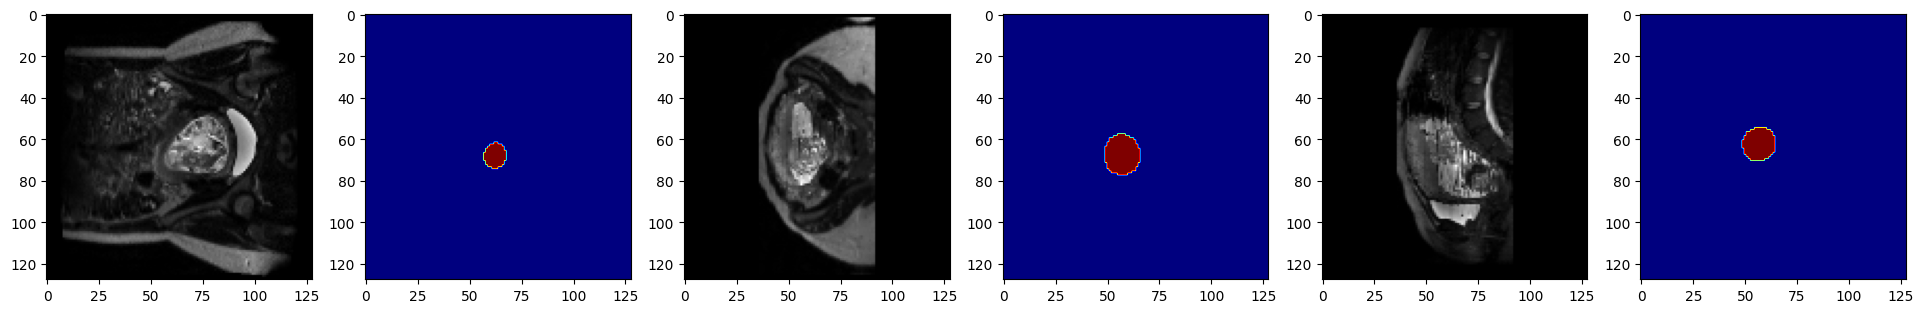

1 presto0016-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


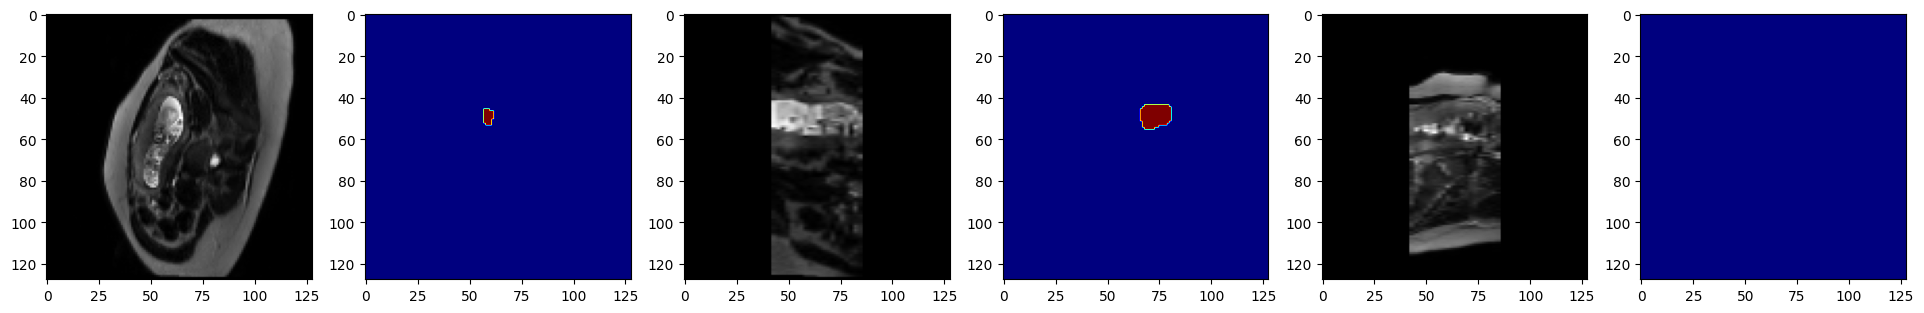

2 presto0033-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


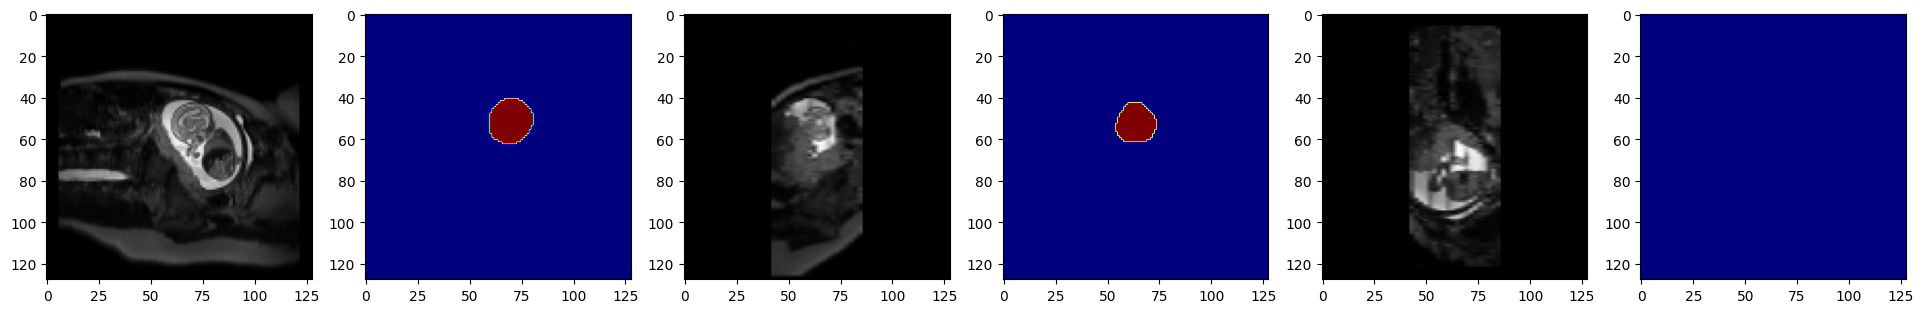

3 presto0041-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


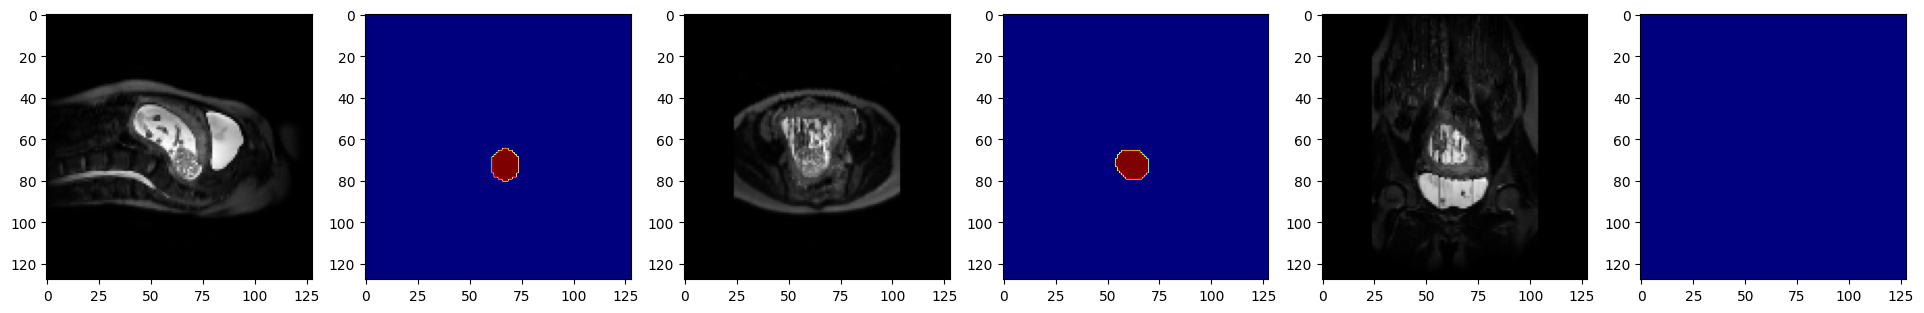

4 presto004102-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


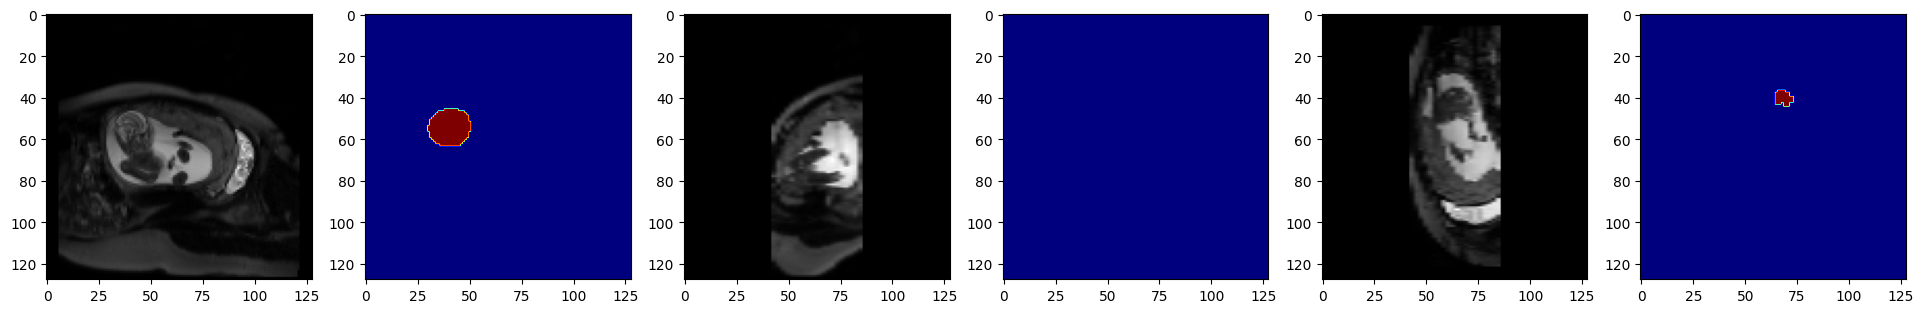

5 presto0048-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


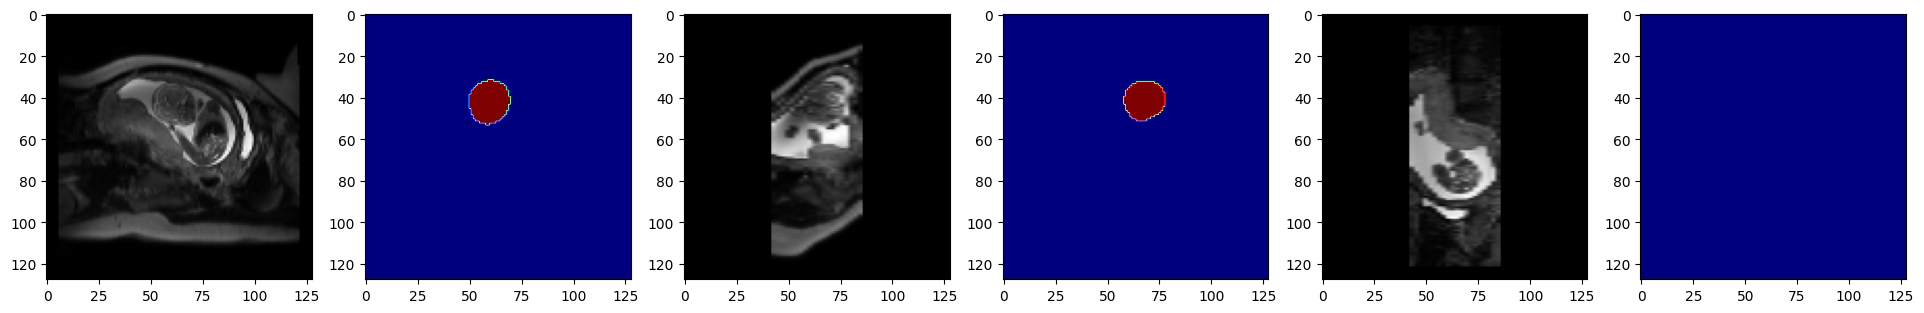

6 presto0052-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


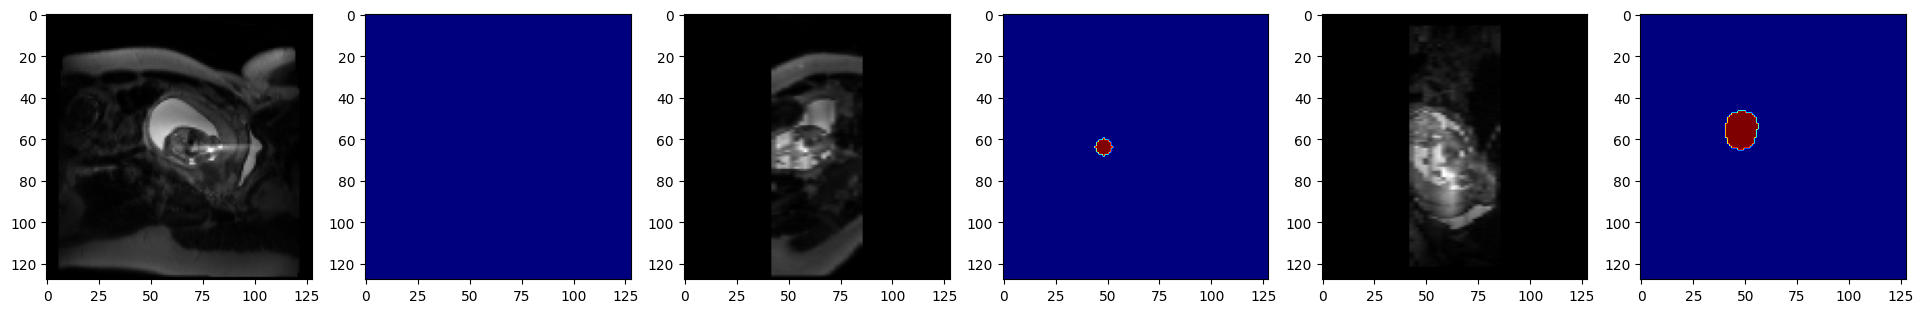

7 presto0053-stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


KeyboardInterrupt: ignored

In [ ]:

s=round(img_dim/2)

for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=val_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()




---



0 stack-1000.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


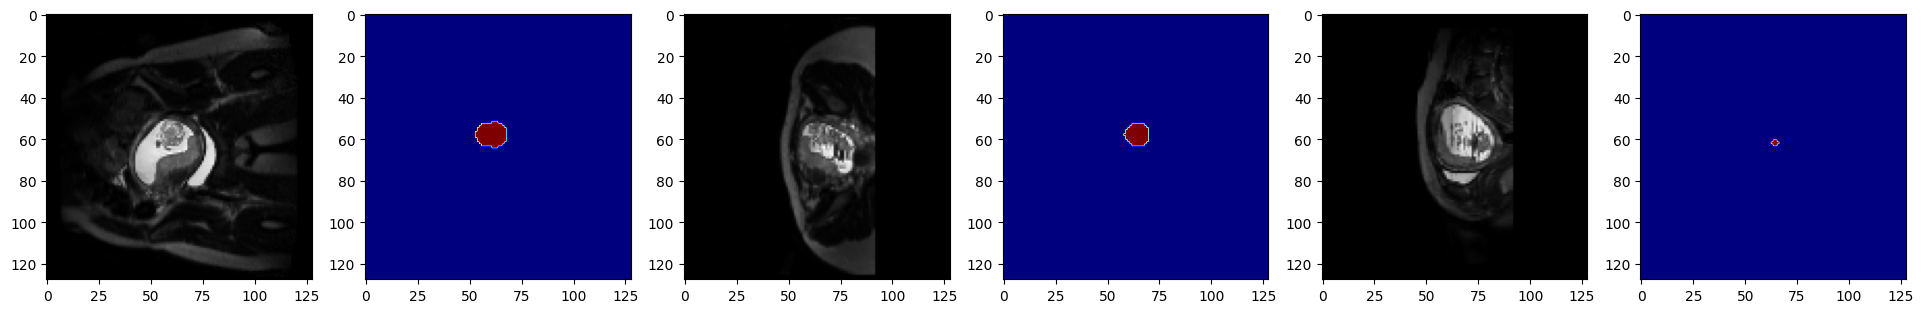

1 stack-1001.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


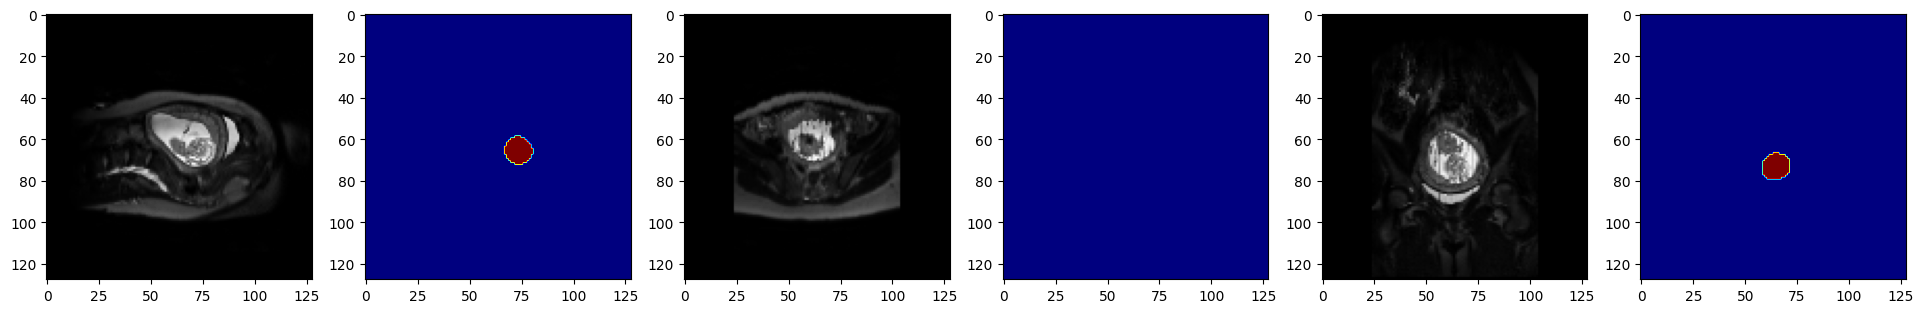

2 stack-1002.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


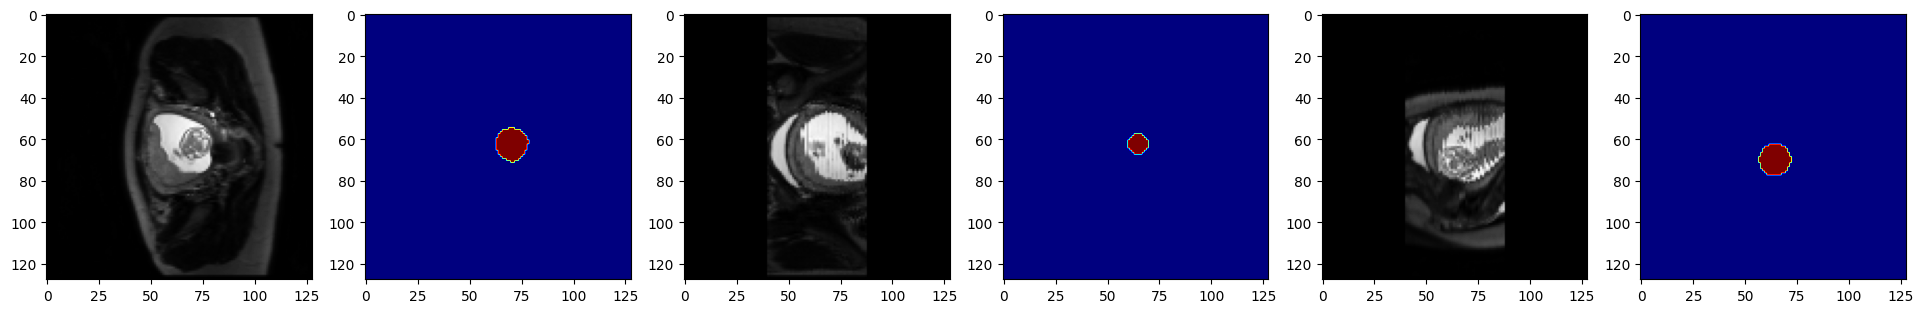

3 stack-1003.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


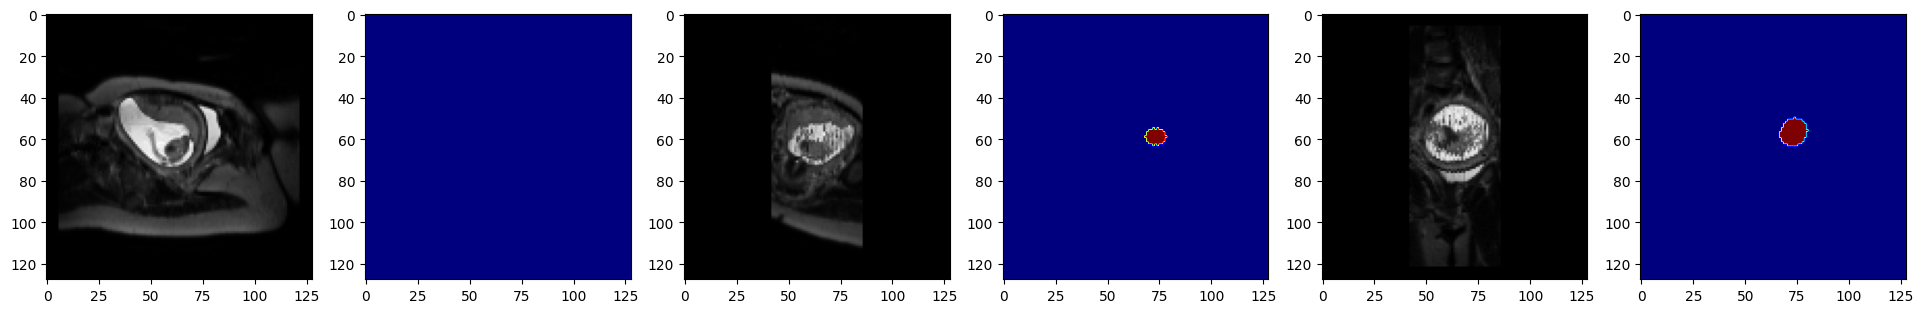

4 stack-1004.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


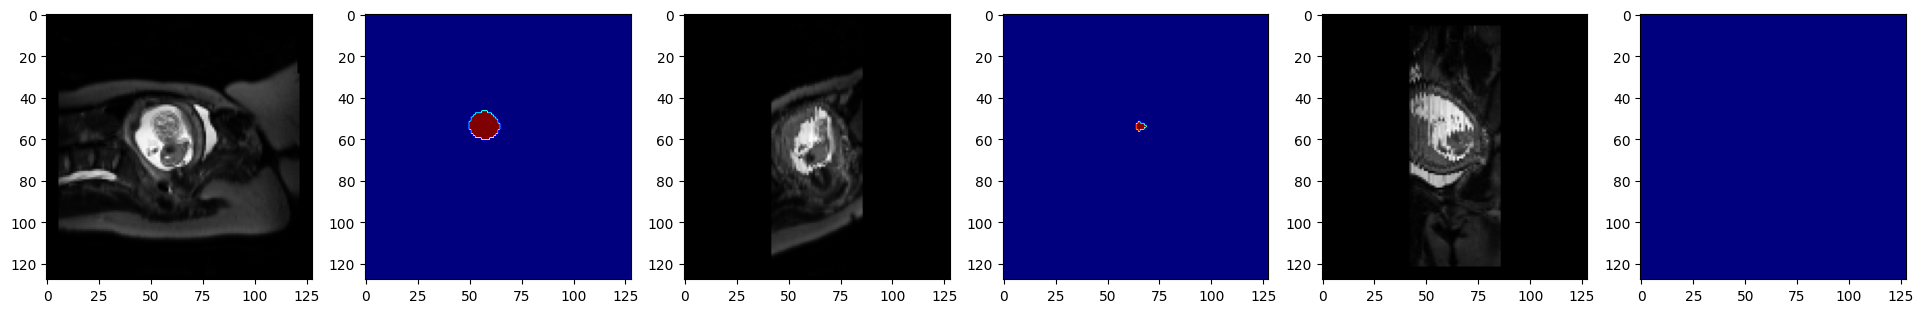

5 stack-1005.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


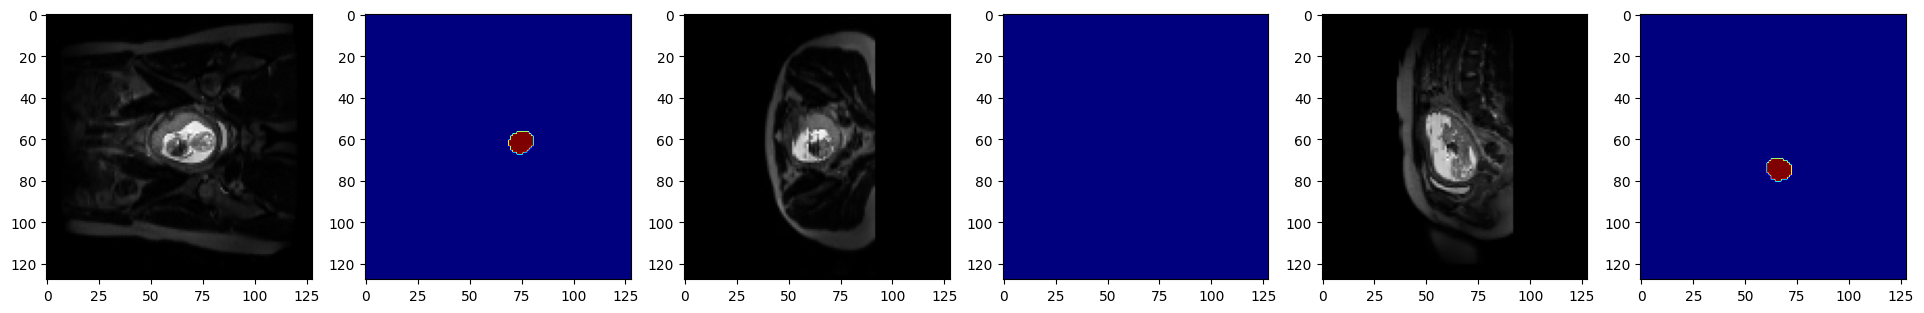

6 stack-1006.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


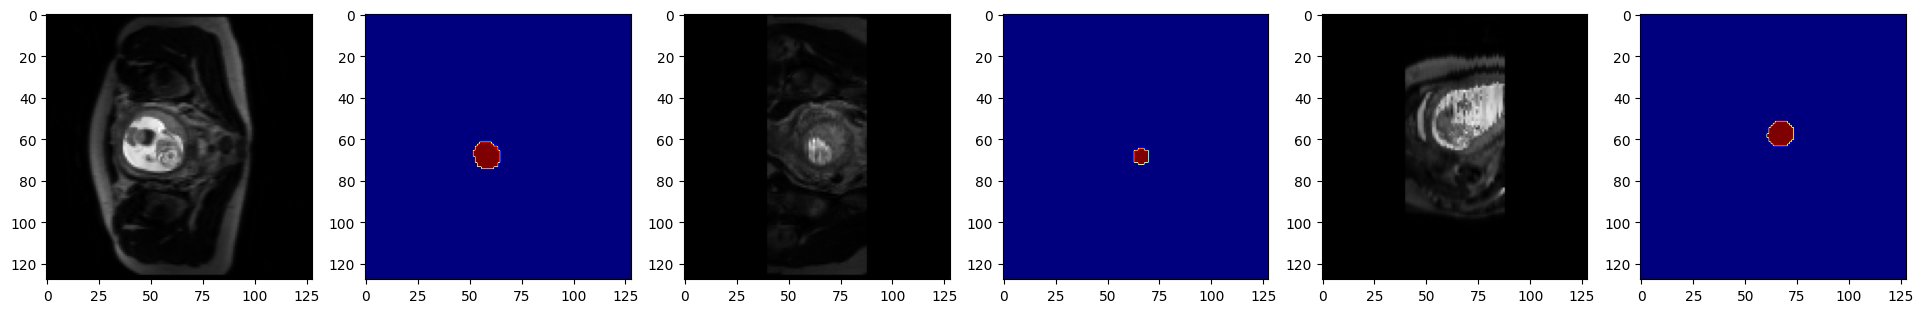

7 stack-1007.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


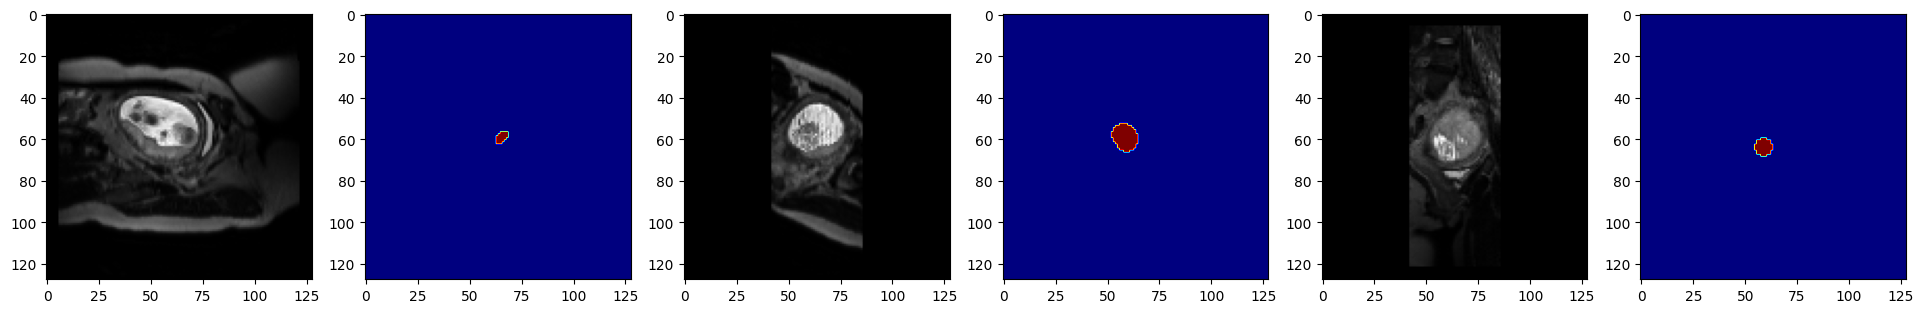

8 stack-1008.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


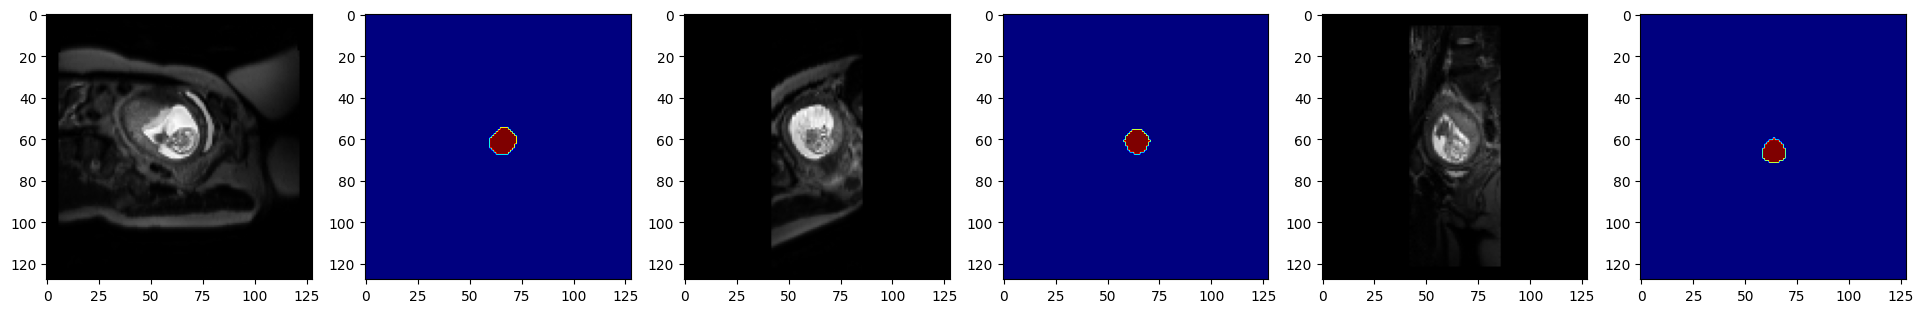

9 stack-1009.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


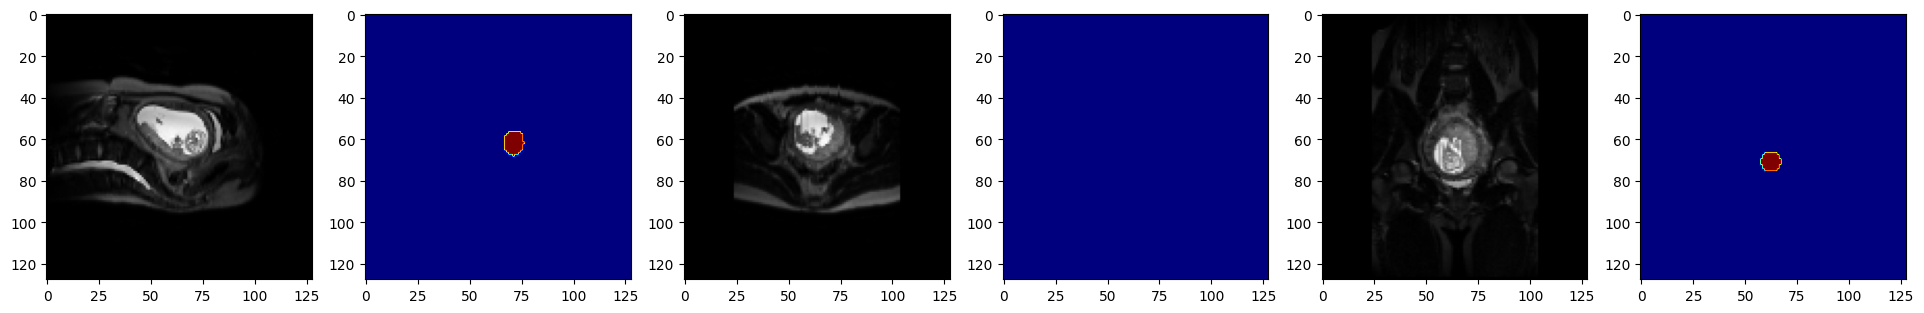

10 stack-1010.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


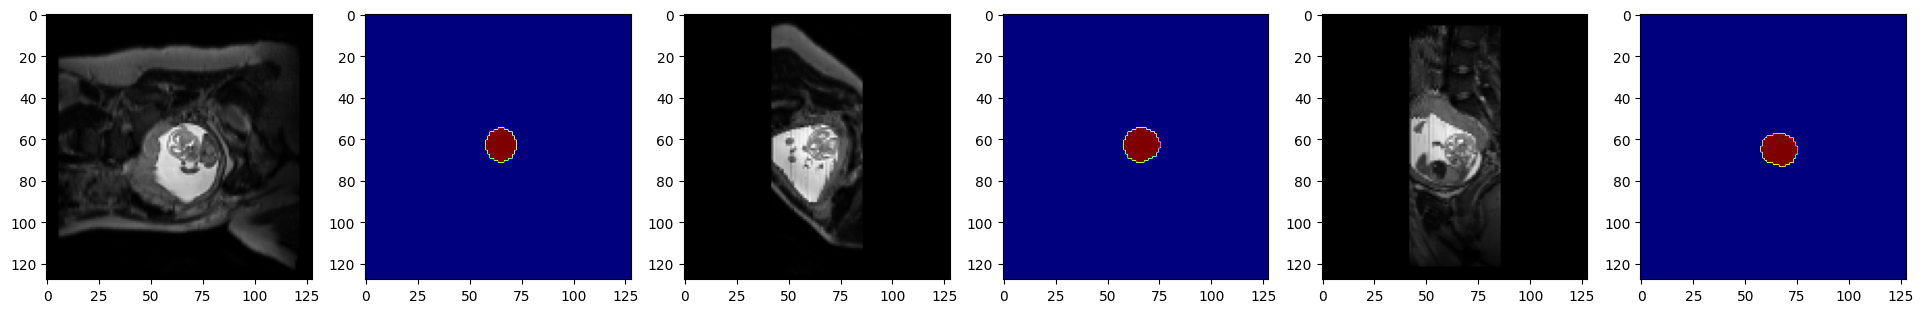

11 stack-1011.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


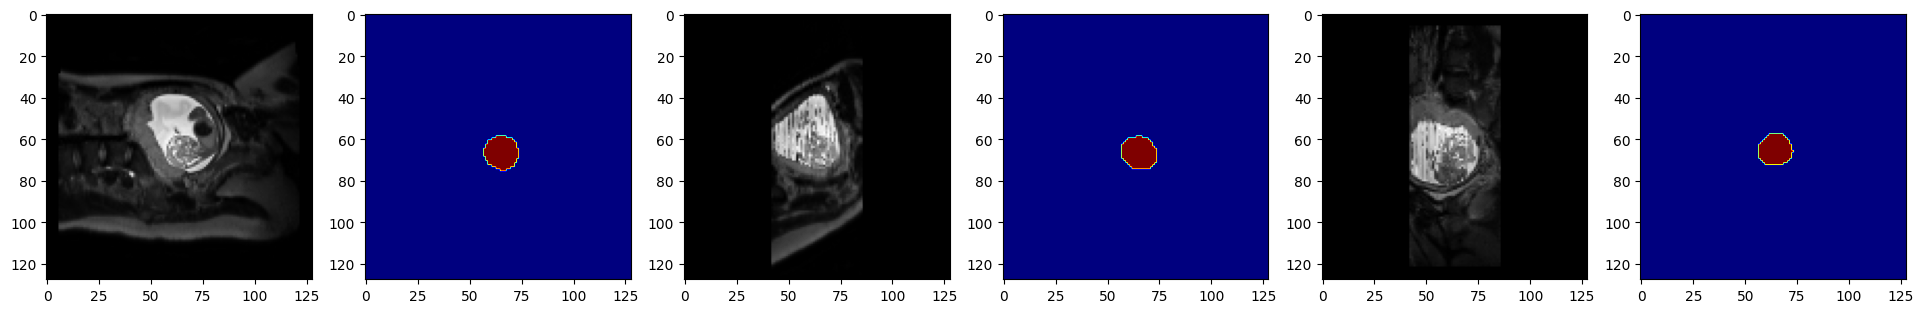

12 stack-1012.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


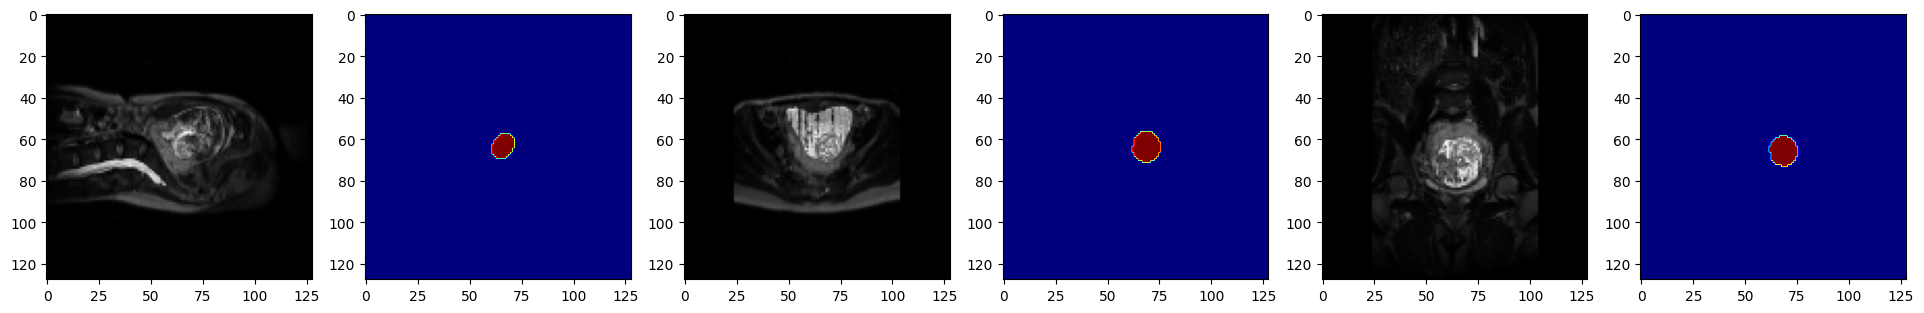

13 stack-1013.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


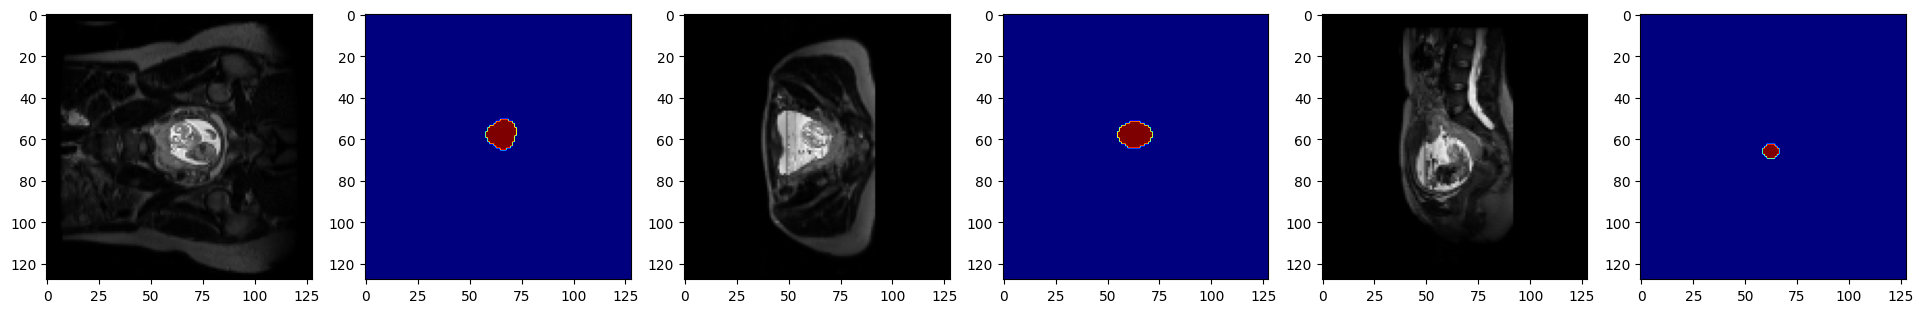

14 stack-1014.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


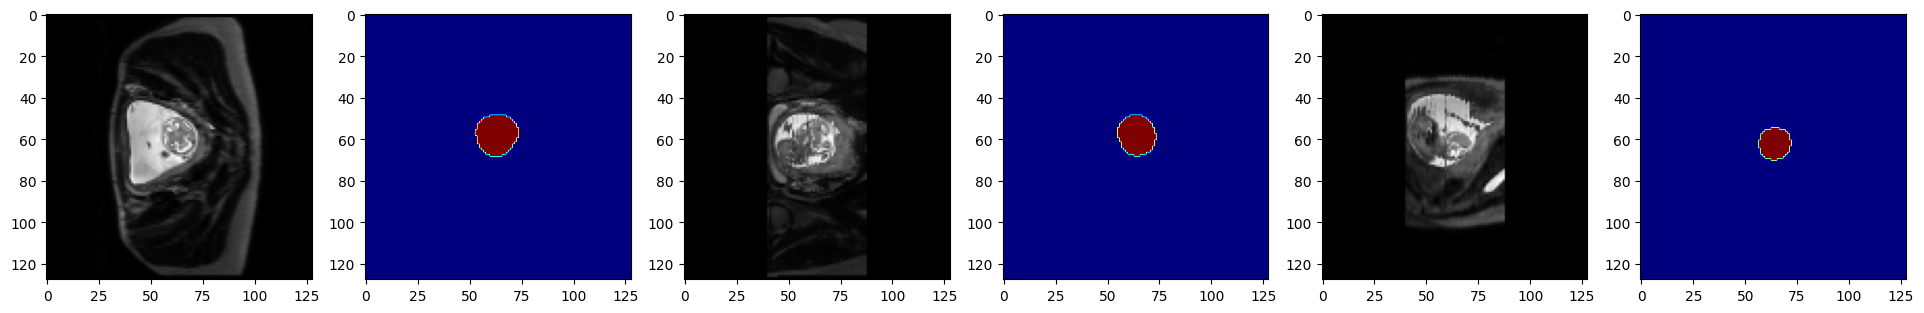

15 stack-1015.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


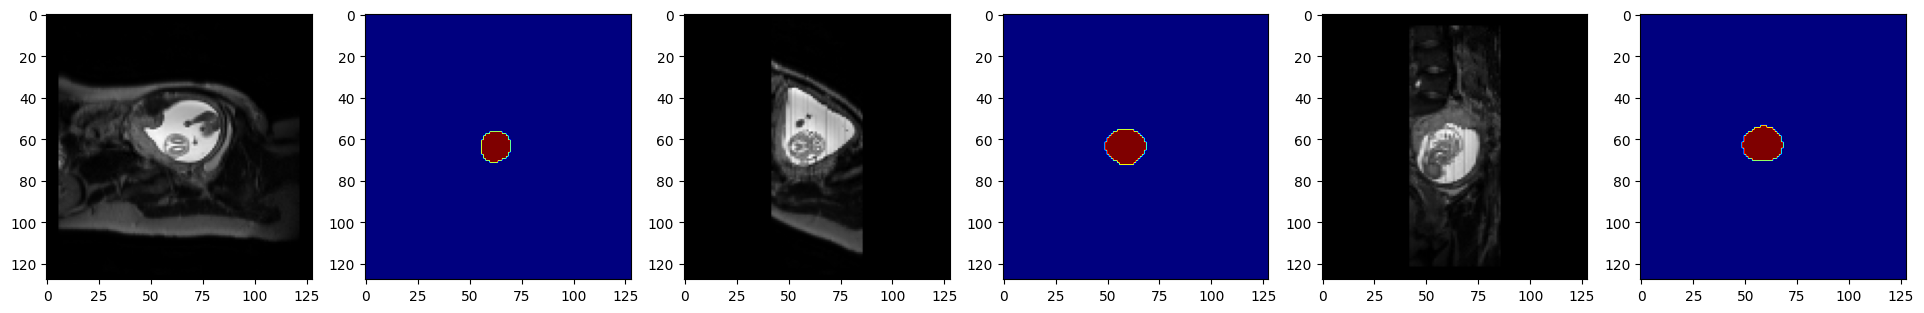

16 stack-1016.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


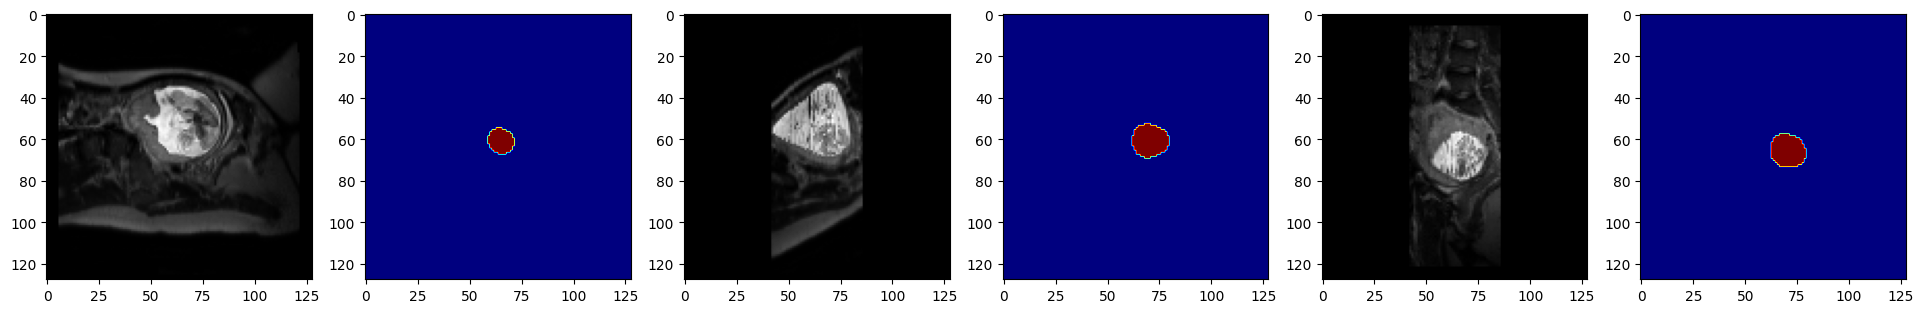

17 stack-1017.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


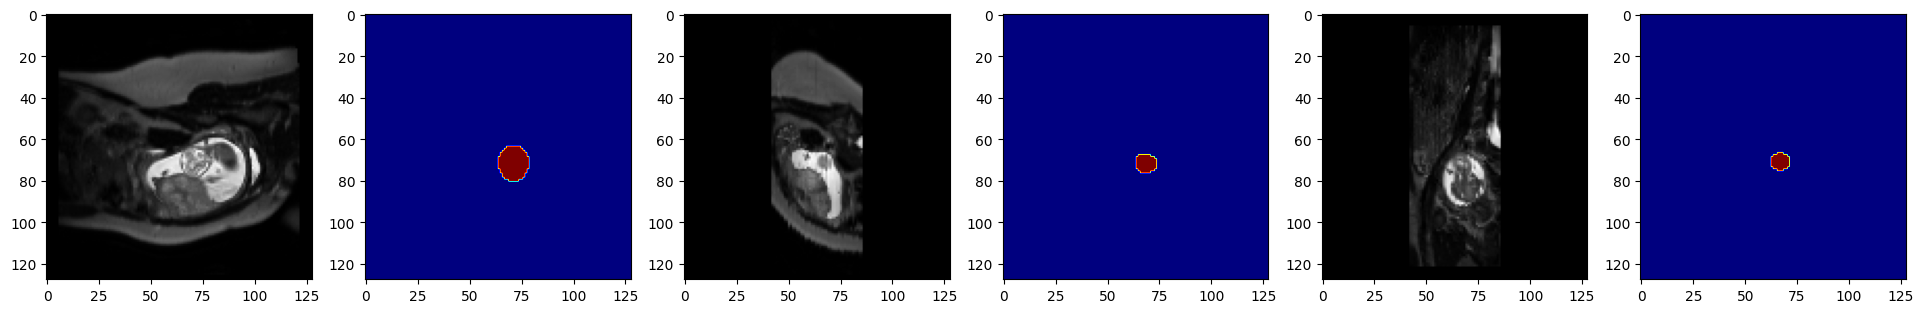

18 stack-1018.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


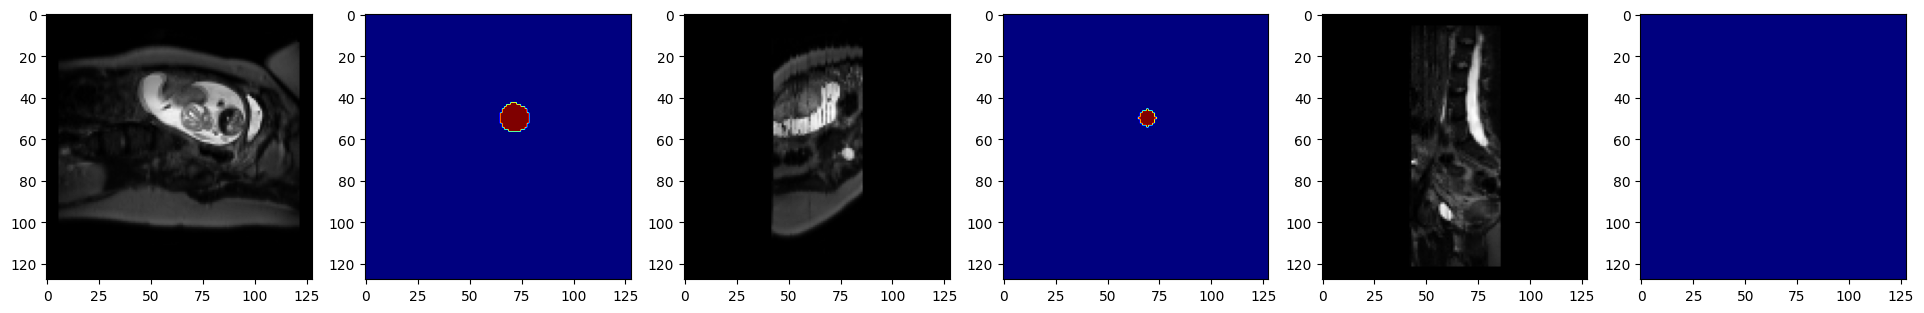

19 stack-1019.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


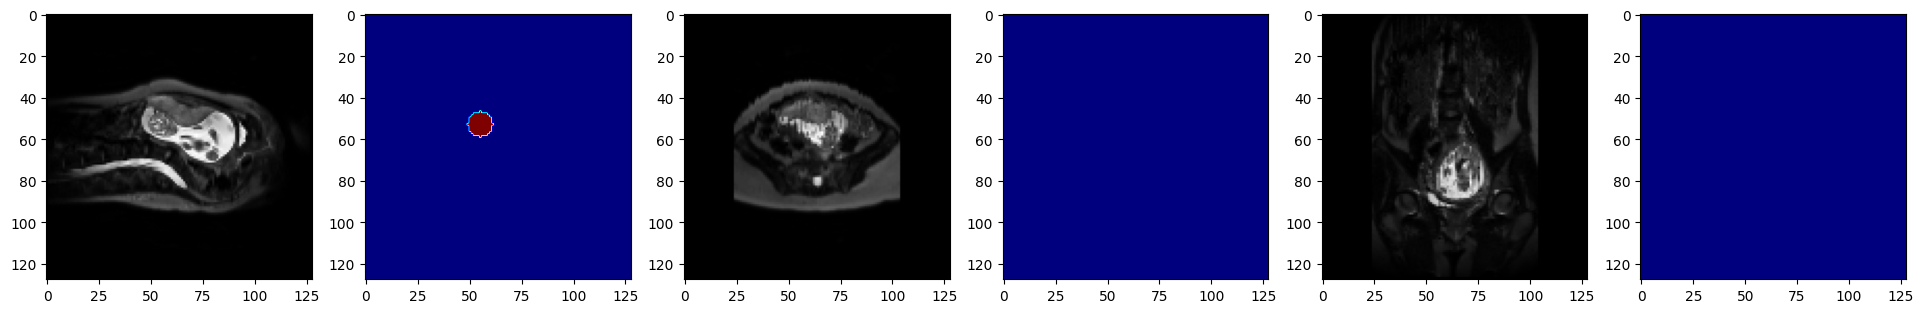

20 stack-1020.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


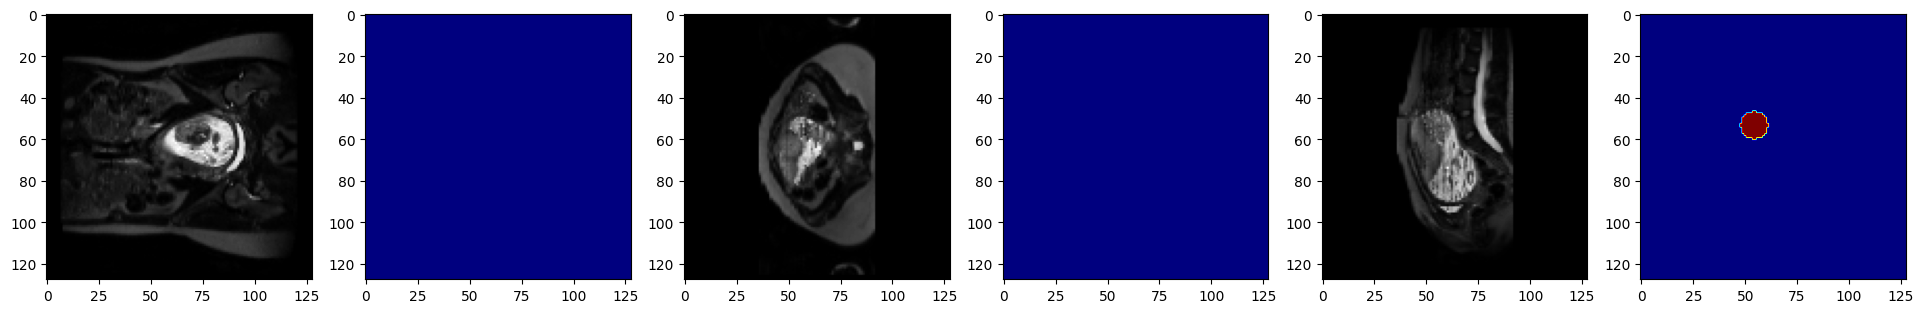

21 stack-1021.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


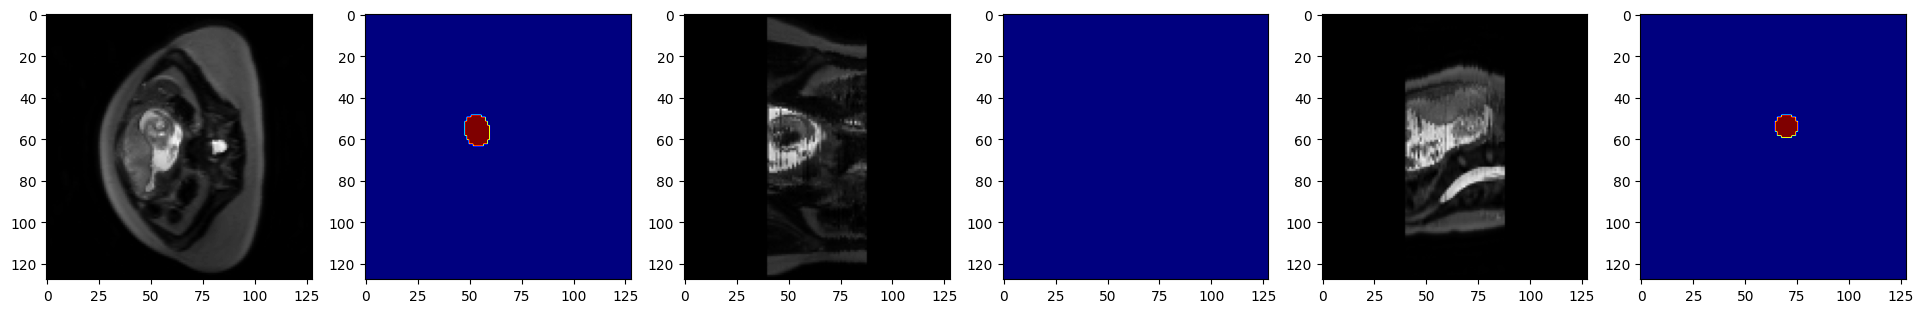

22 stack-1022.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


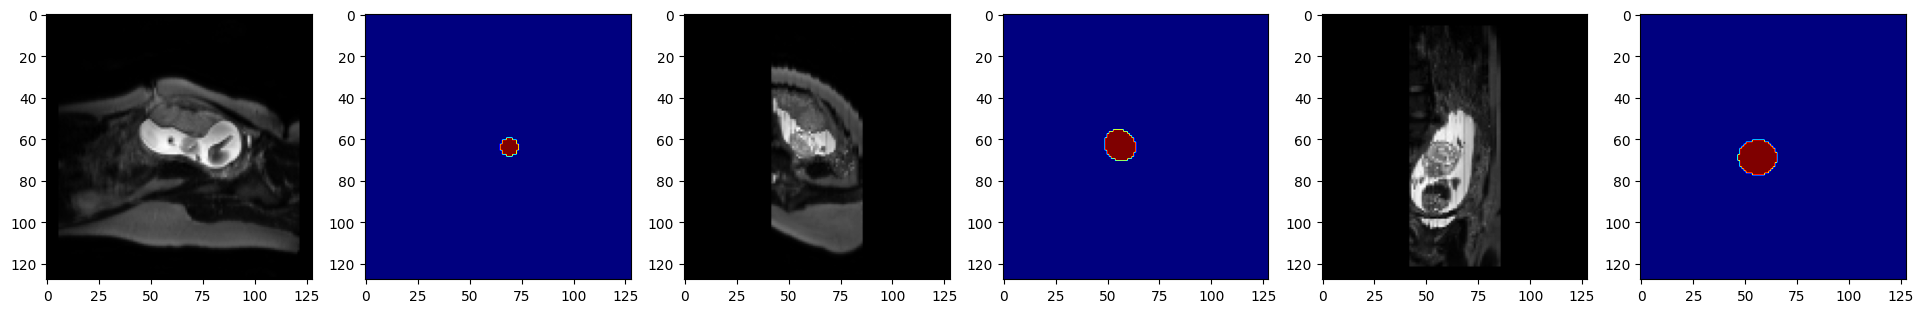

23 stack-1023.nii.gz torch.Size([1, 128, 128, 128]) torch.Size([1, 128, 128, 128])


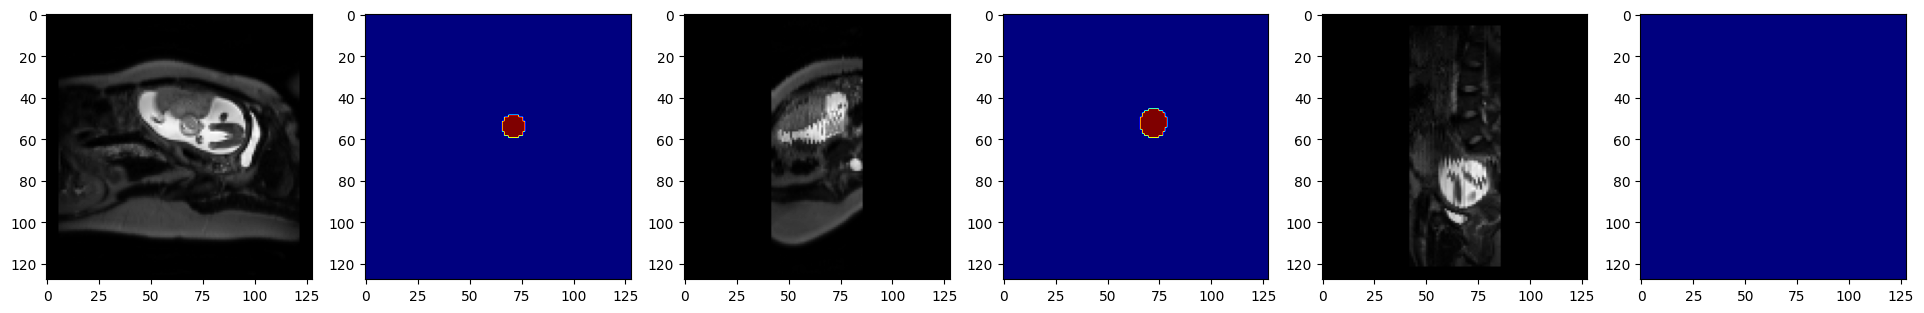

In [ ]:

s=round(img_dim/2)

for x in range(len(test_files)):

  case_num = x
  img_name = test_files[case_num]["label"]
  label_name = test_files[case_num]["label"]
  case_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  case_in=test_ds[case_num]
  img = case_in["image"]
  label = case_in["label"]
  img_shape = img.shape
  label_shape = label.shape

  print(x, case_name, img_shape, label_shape)
  plt.figure("image", (24, 4))
  plt.subplot(1, 6, 1)
  plt.imshow(img[0, :, :, s], cmap="gray")
  plt.subplot(1, 6, 2)
  plt.imshow(label[0, :, :, s], cmap="jet")
  plt.subplot(1, 6, 3)
  plt.imshow(img[0, :, s, :], cmap="gray")
  plt.subplot(1, 6, 4)
  plt.imshow(label[0, :, s, :], cmap="jet")
  plt.subplot(1, 6, 5)
  plt.imshow(img[0, s, :, :], cmap="gray")
  plt.subplot(1, 6, 6)
  plt.imshow(label[0, s, :, :], cmap="jet")
  plt.show()


Define the network using MONAI (see examples in https://github.com/Project-MONAI/tutorials/tree/master/3d_segmentation)

In [ ]:


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3D UNet
model = UNet(spatial_dims=3,
in_channels=1,
out_channels=class_num,
channels=(32, 64, 128, 256, 512),
strides=(2,2,2,2),
kernel_size=3,
up_kernel_size=3,
num_res_units=1,
act='PRELU',
norm='INSTANCE',
dropout=0.5).to(device)

# define the loss and optimiser
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)


Define validation and training functions

In [ ]:
save_dir ='/content/drive/MyDrive/RESIT/Save'
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)

            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]

            # val_labels_list는 이미 원-핫 인코딩된 상태이므로 추가 변환이 필요 없습니다.
            val_labels_list = decollate_batch(val_labels)

            dice_metric(y_pred=val_output_convert, y=val_labels_list)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("best_metric_model3.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("latest_metric_model3.pth"))
                )
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [ ]:
#

def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            val_outputs = sliding_window_inference(val_inputs, (img_dim, img_dim, img_dim), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("teest.pth"))
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                torch.save(
                    model.state_dict(), os.path.join(save_dir, ("teest.pth"))
                )
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best






---



Preload the pretrained model (if it exists)

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"latest_metric_model_6.pth"))))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.5, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.5, inplace=False)
                (A): PReLU(num_pa

In [ ]:
predictions = []

# 테스트 데이터셋에 대한 추론 수행
with torch.no_grad():
    for batch in test_loader:
        inputs = batch["image"].cuda()  # 이미지 데이터를 GPU로 이동
        outputs = model(inputs)  # 모델 추론
        predictions.append(outputs)  # 결과 저장

# predictions 리스트에는 테스트 데이터셋에 대한 추론 결과가 저장됩니다.
# 이 결과를 필요에 따라 사용하여 후처리 또는 성능 평가를 수행할 수 있습니다.

In [ ]:
import numpy as np
import torch
from monai.metrics import ConfusionMatrixMetric, HausdorffDistanceMetric, DiceMetric, MeanIoU

# 테스트 데이터셋에 대한 추론 수행한 결과 (원핫인코딩되지 않은 형태)
predictions = []  # 모델 예측 결과 저장
ground_truths = []  # 실제 레이블 저장

# 테스트 데이터셋에 대한 추론 수행
with torch.no_grad():
    for batch in test_loader:
        inputs = batch["image"].cuda()
        outputs = model(inputs)
        predictions.append(outputs)
        ground_truths.append(batch["label"].cuda())

# 후처리 후 원핫인코딩 적용
def postprocess_prediction(prediction):
    # 각 픽셀에서 최대 값을 갖는 클래스를 찾아서 원핫인코딩 적용
    argmax = torch.argmax(prediction, dim=1)
    one_hot = torch.nn.functional.one_hot(argmax, num_classes=class_num).permute(0, 4, 1, 2, 3)
    return one_hot.float()

def postprocess_gt(gt):
    # 각 픽셀에서 최대 값을 갖는 클래스를 찾아서 원핫인코딩 적용
    argmax = torch.argmax(gt, dim=1)
    one_hot = torch.nn.functional.one_hot(argmax, num_classes=class_num).permute(0, 4, 1, 2, 3)
    return one_hot.float()

# ConfusionMatrixMetric 초기화
confusion_metric = ConfusionMatrixMetric(
    include_background=True,
    metric_name=["sensitivity", "accuracy", "precision", "f1 score", "recall"],
    compute_sample=True,  # 각 샘플의 메트릭 계산
    reduction="mean"  # 결과의 평균을 계산하려면 "mean"을 사용
)

# HausdorffDistanceMetric 초기화
hausdorff_metric = HausdorffDistanceMetric(
    include_background=False,
    distance_metric='euclidean',
    percentile=None,
    directed=False,
    reduction="mean"
)

# MeanDice 초기화
dice_metric = DiceMetric(
    include_background=True,
    reduction="mean"
)

# Mean IoU 초기화
IoU_metric = MeanIoU(
    include_background=True,
    reduction="mean"
)

# 테스트 데이터셋에 대한 메트릭 계산
with torch.no_grad():
    for pred, gt in zip(predictions, ground_truths):
        pred_one_hot = postprocess_prediction(pred)
        gt_one_hot = postprocess_gt(gt)

        confusion_metric(y_pred=pred_one_hot, y=gt_one_hot)
        hausdorff_metric(y_pred=pred_one_hot, y=gt_one_hot)
        dice_metric(y_pred=pred_one_hot, y=gt_one_hot)
        IoU_metric(y_pred=pred_one_hot, y=gt_one_hot)

# 평가 결과 얻기
sensitivity_result, accuracy_result, precision_result, f1_score_result, recall_result = confusion_metric.aggregate()
hausdorff_result = hausdorff_metric.aggregate()
dice_result = dice_metric.aggregate()
IoU_result = IoU_metric.aggregate()

print("Mean Sensitivity:", round(sensitivity_result.item(),2))
print("Mean Accuracy:", accuracy_result.item())
print("Mean Precision:", precision_result.item())
print("Mean F1 Score:", f1_score_result.item())
print("Mean Recall:", recall_result.item())

print("Mean Hausdorff Distance:", hausdorff_result.item())

print("Mean Dice Metric:", dice_result.item())

print("Mean IoU Metric:", IoU_result.item())

Mean Sensitivity: 0.9986109733581543
Mean Accuracy: 0.9986109733581543
Mean Precision: 0.5
Mean F1 Score: 0.4996524751186371
Mean Recall: 0.9986109733581543
Mean Hausdorff Distance: inf
Mean Dice Metric: 0.9993049502372742
Mean IoU Metric: 0.9986109733581543


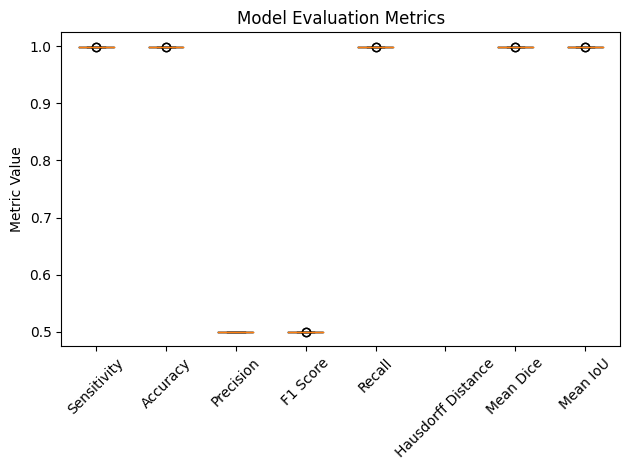

In [ ]:
# 테스트 데이터셋에 대한 메트릭 계산
sensitivity_results = []
accuracy_results = []
precision_results = []
f1_score_results = []
recall_results = []
hausdorff_results = []
dice_results = []
IoU_results = []

with torch.no_grad():
    for pred, gt in zip(predictions, ground_truths):
        pred_one_hot = postprocess_prediction(pred)
        gt_one_hot = postprocess_gt(gt)

        confusion_metric(y_pred=pred_one_hot, y=gt_one_hot)
        hausdorff_metric(y_pred=pred_one_hot, y=gt_one_hot)
        dice_metric(y_pred=pred_one_hot, y=gt_one_hot)
        IoU_metric(y_pred=pred_one_hot, y=gt_one_hot)

        sensitivity, accuracy, precision, f1_score, recall = confusion_metric.aggregate()
        hausdorff_distance = hausdorff_metric.aggregate()
        dice = dice_metric.aggregate()
        IoU = IoU_metric.aggregate()

        sensitivity_results.append(sensitivity.item())
        accuracy_results.append(accuracy.item())
        precision_results.append(precision.item())
        f1_score_results.append(f1_score.item())
        recall_results.append(recall.item())

        hausdorff_results.append(hausdorff_distance.item())
        dice_results.append(dice.item())
        IoU_results.append(IoU.item())

# 결과 시각화
results = [sensitivity_results, accuracy_results, precision_results, f1_score_results, recall_results, hausdorff_results, dice_results, IoU_results]
labels = ["Sensitivity", "Accuracy", "Precision", "F1 Score", "Recall", "Hausdorff Distance", "Mean Dice", "Mean IoU"]

plt.boxplot(results, labels=labels)
plt.xticks(rotation=45)
plt.ylabel("Metric Value")
plt.title("Model Evaluation Metrics")
plt.tight_layout()
plt.show()

Define training parameters.

In [ ]:
# 검증 데이터셋에 대한 추론 수행한 결과 (원핫인코딩되지 않은 형태)
val_predictions = []  # 모델 예측 결과 저장
val_ground_truths = []  # 실제 레이블 저장

# 검증 데이터셋에 대한 추론 수행
with torch.no_grad():
    for batch in val_loader:
        inputs = batch["image"].cuda()
        outputs = model(inputs)
        val_predictions.append(outputs)
        val_ground_truths.append(batch["label"].cuda())

# ...

# 검증 데이터셋에 대한 메트릭 계산
with torch.no_grad():
    for val_pred, val_gt in zip(val_predictions, val_ground_truths):
        val_pred_one_hot = postprocess_prediction(val_pred)
        val_gt_one_hot = postprocess_gt(val_gt)

        confusion_metric(y_pred=val_pred_one_hot, y=val_gt_one_hot)
        hausdorff_metric(y_pred=val_pred_one_hot, y=val_gt_one_hot)
        dice_metric(y_pred=val_pred_one_hot, y=val_gt_one_hot)
        IoU_metric(y_pred=val_pred_one_hot, y=val_gt_one_hot)

# 검증 데이터셋에 대한 평가 결과 얻기
val_sensitivity_result, val_accuracy_result, val_precision_result, val_f1_score_result, val_recall_result = confusion_metric.aggregate()
val_hausdorff_result = hausdorff_metric.aggregate()
val_dice_result = dice_metric.aggregate()
val_IoU_result = IoU_metric.aggregate()

print("Validation Mean Sensitivity:", val_sensitivity_result.item())
print("Validation Mean Accuracy:", val_accuracy_result.item())
print("Validation Mean Precision:", val_precision_result.item())
print("Validation Mean F1 Score:", val_f1_score_result.item())
print("Validation Mean Recall:", val_recall_result.item())

print("Validation Mean Hausdorff Distance:", val_hausdorff_result.item())

print("Validation Mean Dice Metric:", val_dice_result.item())

print("Validation Mean IoU Metric:", val_IoU_result.item())

Validation Mean Sensitivity: 0.9984159469604492
Validation Mean Accuracy: 0.9984159469604492
Validation Mean Precision: 0.5
Validation Mean F1 Score: 0.49960359930992126
Validation Mean Recall: 0.9984159469604492
Validation Mean Hausdorff Distance: inf
Validation Mean Dice Metric: 0.9992071986198425
Validation Mean IoU Metric: 0.9984159469604492


In [ ]:
# 테스트 데이터셋에 대한 메트릭 계산
sensitivity_results = []
accuracy_results = []
precision_results = []
f1_score_results = []
recall_results = []
hausdorff_results = []
dice_results = []
IoU_results = []

with torch.no_grad():
    for pred, gt in zip(predictions, ground_truths):
        pred_one_hot = postprocess_prediction(pred)
        gt_one_hot = postprocess_gt(gt)

        confusion_metric(y_pred=pred_one_hot, y=gt_one_hot)
        hausdorff_metric(y_pred=pred_one_hot, y=gt_one_hot)
        dice_metric(y_pred=pred_one_hot, y=gt_one_hot)
        IoU_metric(y_pred=pred_one_hot, y=gt_one_hot)

        sensitivity, accuracy, precision, f1_score, recall = confusion_metric.aggregate()
        hausdorff_distance = hausdorff_metric.aggregate()
        dice = dice_metric.aggregate()
        IoU = IoU_metric.aggregate()

        sensitivity_results.append(sensitivity.item())
        accuracy_results.append(accuracy.item())
        precision_results.append(precision.item())
        f1_score_results.append(f1_score.item())
        recall_results.append(recall.item())

        hausdorff_results.append(hausdorff_distance.item())
        dice_results.append(dice.item())
        IoU_results.append(IoU.item())

# 결과 시각화
results = [sensitivity_results, accuracy_results, precision_results, f1_score_results, recall_results, hausdorff_results, dice_results, IoU_results]
labels = ["Sensitivity", "Accuracy", "Precision", "F1 Score", "Recall", "Hausdorff Distance", "Mean Dice", "Mean IoU"]

plt.boxplot(results, labels=labels)
plt.xticks(rotation=45)
plt.ylabel("Metric Value")
plt.title("Model Evaluation Metrics")
plt.tight_layout()
plt.show()

In [ ]:
max_iterations = 50000
eval_num = 200
post_label = AsDiscrete(to_onehot=class_num)
post_pred = AsDiscrete(argmax=True, to_onehot=class_num)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []


Run training. The model will be saved in the folder on your Drive. You can stop training at any moment (e.g., when the Dice is not increasing any more).

In [ ]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )


Training (200 / 50000 Steps) (loss=0.75554):  14%|█▍        | 13/94 [00:20<04:42,  3.49s/it]

Model Was Saved ! Current Best Avg. Dice: 0.4646890705282038 Current Avg. Dice: 0.4646890705282038


Training (400 / 50000 Steps) (loss=0.63736):  27%|██▋       | 25/94 [00:24<02:13,  1.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5724083889614452 Current Avg. Dice: 0.5724083889614452


Training (600 / 50000 Steps) (loss=0.58022):  39%|███▉      | 37/94 [00:31<01:43,  1.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5850177298892628 Current Avg. Dice: 0.5850177298892628


Training (800 / 50000 Steps) (loss=0.54425):  52%|█████▏    | 49/94 [00:39<01:43,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5850177298892628 Current Avg. Dice: 0.583958549933


Training (1000 / 50000 Steps) (loss=0.52256):  65%|██████▍   | 61/94 [00:44<01:00,  1.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5856638225642118 Current Avg. Dice: 0.5856638225642118


Training (1200 / 50000 Steps) (loss=0.50533):  78%|███████▊  | 73/94 [00:52<00:38,  1.85s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.5856638225642118 Current Avg. Dice: 0.5835439779541709


Training (1400 / 50000 Steps) (loss=0.48827):  90%|█████████ | 85/94 [00:55<00:09,  1.03s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6053626483136957 Current Avg. Dice: 0.6053626483136957


Training (1600 / 50000 Steps) (loss=0.43685):   3%|▎         | 3/94 [00:11<06:01,  3.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6071849682114341 Current Avg. Dice: 0.6071849682114341


Training (1800 / 50000 Steps) (loss=0.44791):  16%|█▌        | 15/94 [00:17<02:54,  2.21s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6203119321302935 Current Avg. Dice: 0.6203119321302935


Training (2000 / 50000 Steps) (loss=0.47720):  29%|██▊       | 27/94 [00:26<02:29,  2.23s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6339391740885648 Current Avg. Dice: 0.6339391740885648


Training (2200 / 50000 Steps) (loss=0.48735):  41%|████▏     | 39/94 [00:33<02:10,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6463859568942677 Current Avg. Dice: 0.6463859568942677


Training (2400 / 50000 Steps) (loss=0.43963):  54%|█████▍    | 51/94 [00:38<01:11,  1.65s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6463859568942677 Current Avg. Dice: 0.6390693404457786


Training (2600 / 50000 Steps) (loss=0.42658):  67%|██████▋   | 63/94 [00:46<01:06,  2.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6712482246485624 Current Avg. Dice: 0.6712482246485624


Training (2800 / 50000 Steps) (loss=0.30528):  80%|███████▉  | 75/94 [00:53<00:40,  2.12s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6856961737979542 Current Avg. Dice: 0.6856961737979542


Training (3000 / 50000 Steps) (loss=0.35575):  93%|█████████▎| 87/94 [00:57<00:07,  1.04s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6960706819187511 Current Avg. Dice: 0.6960706819187511


Training (3200 / 50000 Steps) (loss=0.31633):   5%|▌         | 5/94 [00:12<03:42,  2.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7065519527955488 Current Avg. Dice: 0.7065519527955488


Training (3400 / 50000 Steps) (loss=0.32931):  18%|█▊        | 17/94 [00:20<02:52,  2.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.734658187085932 Current Avg. Dice: 0.734658187085932


Training (3600 / 50000 Steps) (loss=0.42204):  31%|███       | 29/94 [00:26<02:16,  2.11s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7681100910360162 Current Avg. Dice: 0.7681100910360162


Training (3800 / 50000 Steps) (loss=0.37756):  44%|████▎     | 41/94 [00:32<01:57,  2.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.7681100910360162 Current Avg. Dice: 0.7639444687149741


Training (4000 / 50000 Steps) (loss=0.37237):  56%|█████▋    | 53/94 [00:41<01:23,  2.04s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7773168303749778 Current Avg. Dice: 0.7773168303749778


Training (4200 / 50000 Steps) (loss=0.36024):  69%|██████▉   | 65/94 [00:46<01:02,  2.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8133342970501293 Current Avg. Dice: 0.8133342970501293


Training (4400 / 50000 Steps) (loss=0.36032):  82%|████████▏ | 77/94 [00:55<00:37,  2.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8133342970501293 Current Avg. Dice: 0.7814224850047718


Training (4600 / 50000 Steps) (loss=0.23760):  95%|█████████▍| 89/94 [00:56<00:04,  1.02it/s]

Model Was Saved ! Current Best Avg. Dice: 0.8136311877857555 Current Avg. Dice: 0.8136311877857555


Training (4800 / 50000 Steps) (loss=0.40232):   7%|▋         | 7/94 [00:13<03:31,  2.43s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8240249427882108 Current Avg. Dice: 0.8240249427882108


Training (5000 / 50000 Steps) (loss=0.32195):  20%|██        | 19/94 [00:20<03:05,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8240249427882108 Current Avg. Dice: 0.8192628080194647


Training (5200 / 50000 Steps) (loss=0.22781):  33%|███▎      | 31/94 [00:26<02:09,  2.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8240249427882108 Current Avg. Dice: 0.8181979276917197


Training (5400 / 50000 Steps) (loss=0.30051):  46%|████▌     | 43/94 [00:36<02:17,  2.69s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8240249427882108 Current Avg. Dice: 0.8043127818541094


Training (5600 / 50000 Steps) (loss=0.31467):  59%|█████▊    | 55/94 [00:42<01:34,  2.42s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8240249427882108 Current Avg. Dice: 0.8109685724431818


Training (5800 / 50000 Steps) (loss=0.26985):  71%|███████▏  | 67/94 [00:48<00:56,  2.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.838154364715923 Current Avg. Dice: 0.838154364715923


Training (6000 / 50000 Steps) (loss=0.18357):  84%|████████▍ | 79/94 [00:52<00:26,  1.76s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.838154364715923 Current Avg. Dice: 0.826316161589189


Training (6200 / 50000 Steps) (loss=0.25034):  97%|█████████▋| 91/94 [00:56<00:02,  1.05it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.838154364715923 Current Avg. Dice: 0.8252850716764276


Training (6400 / 50000 Steps) (loss=0.21167):  10%|▉         | 9/94 [00:15<03:32,  2.50s/it]

Model Was Saved ! Current Best Avg. Dice: 0.850802253593098 Current Avg. Dice: 0.850802253593098


Training (6600 / 50000 Steps) (loss=0.38004):  22%|██▏       | 21/94 [00:22<02:17,  1.89s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8549121455712752 Current Avg. Dice: 0.8549121455712752


Training (6800 / 50000 Steps) (loss=0.37554):  35%|███▌      | 33/94 [00:28<01:59,  1.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8549121455712752 Current Avg. Dice: 0.8278924606063149


Training (7000 / 50000 Steps) (loss=0.28090):  48%|████▊     | 45/94 [00:38<01:34,  1.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8549121455712752 Current Avg. Dice: 0.8475528142668984


Training (7200 / 50000 Steps) (loss=0.19245):  61%|██████    | 57/94 [00:41<01:07,  1.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8567377166314558 Current Avg. Dice: 0.8567377166314558


Training (7400 / 50000 Steps) (loss=0.22580):  73%|███████▎  | 69/94 [00:51<00:45,  1.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8567377166314558 Current Avg. Dice: 0.8391320163553412


Training (7600 / 50000 Steps) (loss=0.24386):  86%|████████▌ | 81/94 [00:55<00:20,  1.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8594957644289191 Current Avg. Dice: 0.8594957644289191


Training (7800 / 50000 Steps) (loss=0.21173):  99%|█████████▉| 93/94 [00:55<00:01,  1.02s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8660508448427374 Current Avg. Dice: 0.8660508448427374


Training (8000 / 50000 Steps) (loss=0.27922):  12%|█▏        | 11/94 [00:15<02:57,  2.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8826782161539252 Current Avg. Dice: 0.8826782161539252


Training (8200 / 50000 Steps) (loss=0.31102):  24%|██▍       | 23/94 [00:22<02:18,  1.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8826782161539252 Current Avg. Dice: 0.8670239394361322


Training (8400 / 50000 Steps) (loss=0.26792):  37%|███▋      | 35/94 [00:29<01:57,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8826782161539252 Current Avg. Dice: 0.8822517124089327


Training (8600 / 50000 Steps) (loss=0.40390):  50%|█████     | 47/94 [00:35<01:21,  1.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8826782161539252 Current Avg. Dice: 0.8584813909097151


Training (8800 / 50000 Steps) (loss=0.32659):  63%|██████▎   | 59/94 [00:43<01:11,  2.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.8888074809854681


Training (9000 / 50000 Steps) (loss=0.30013):  76%|███████▌  | 71/94 [00:51<00:47,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.8705961595882069


Training (9200 / 50000 Steps) (loss=0.30097):  88%|████████▊ | 83/94 [00:55<00:16,  1.46s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.8547709909352389


Training (9400 / 50000 Steps) (loss=0.17322):   1%|          | 1/94 [00:11<18:27, 11.90s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.866132216020064


Training (9600 / 50000 Steps) (loss=0.46722):  14%|█▍        | 13/94 [00:17<02:46,  2.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.8728507919745012


Training (9800 / 50000 Steps) (loss=0.24019):  27%|██▋       | 25/94 [00:24<02:29,  2.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.8784256631677801


Training (10000 / 50000 Steps) (loss=0.30646):  39%|███▉      | 37/94 [00:30<01:52,  1.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.885843509977514


Training (10200 / 50000 Steps) (loss=0.34267):  52%|█████▏    | 49/94 [00:38<01:40,  2.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8888074809854681 Current Avg. Dice: 0.8443100127306852


Training (10400 / 50000 Steps) (loss=0.29356):  65%|██████▍   | 61/94 [00:44<01:11,  2.16s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.8903181227770719


Training (10600 / 50000 Steps) (loss=0.27177):  78%|███████▊  | 73/94 [00:50<00:45,  2.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.88737445527857


Training (10800 / 50000 Steps) (loss=0.30401):  90%|█████████ | 85/94 [00:54<00:12,  1.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.8899201859127391


Training (11000 / 50000 Steps) (loss=0.23264):   3%|▎         | 3/94 [00:12<06:21,  4.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.8837862068956549


Training (11200 / 50000 Steps) (loss=0.23355):  16%|█▌        | 15/94 [00:19<02:50,  2.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.8862245299599387


Training (11400 / 50000 Steps) (loss=0.18334):  29%|██▊       | 27/94 [00:24<02:25,  2.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.8810553875836459


Training (11600 / 50000 Steps) (loss=0.38104):  41%|████▏     | 39/94 [00:33<01:51,  2.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.8820521127093922


Training (11800 / 50000 Steps) (loss=0.20879):  54%|█████▍    | 51/94 [00:37<01:18,  1.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8903181227770719 Current Avg. Dice: 0.8645117878913879


Training (12000 / 50000 Steps) (loss=0.21128):  67%|██████▋   | 63/94 [00:45<01:10,  2.29s/it]

Model Was Saved ! Current Best Avg. Dice: 0.895317326892506 Current Avg. Dice: 0.895317326892506


Training (12200 / 50000 Steps) (loss=0.24407):  80%|███████▉  | 75/94 [00:50<00:39,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.895317326892506 Current Avg. Dice: 0.8885471387342974


Training (12400 / 50000 Steps) (loss=0.19857):  93%|█████████▎| 87/94 [00:55<00:07,  1.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.895317326892506 Current Avg. Dice: 0.893470661206679


Training (12600 / 50000 Steps) (loss=0.13461):   5%|▌         | 5/94 [00:12<04:02,  2.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.895317326892506 Current Avg. Dice: 0.8694759878245267


Training (12800 / 50000 Steps) (loss=0.18310):  18%|█▊        | 17/94 [00:18<02:31,  1.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8958599404855208 Current Avg. Dice: 0.8958599404855208


Training (13000 / 50000 Steps) (loss=0.33023):  31%|███       | 29/94 [00:29<02:49,  2.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8958599404855208 Current Avg. Dice: 0.8951103362170133


Training (13200 / 50000 Steps) (loss=0.23793):  44%|████▎     | 41/94 [00:31<01:55,  2.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.9054493633183566


Training (13400 / 50000 Steps) (loss=0.22461):  56%|█████▋    | 53/94 [00:41<01:44,  2.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8984584591605447


Training (13600 / 50000 Steps) (loss=0.14845):  69%|██████▉   | 65/94 [00:47<00:59,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8990789326754484


Training (13800 / 50000 Steps) (loss=0.17833):  82%|████████▏ | 77/94 [00:55<00:36,  2.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8915581974116239


Training (14000 / 50000 Steps) (loss=0.42086):  95%|█████████▍| 89/94 [00:57<00:05,  1.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8857916051691229


Training (14200 / 50000 Steps) (loss=0.15504):   7%|▋         | 7/94 [00:13<03:26,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.9051416191187772


Training (14400 / 50000 Steps) (loss=0.35883):  20%|██        | 19/94 [00:20<02:41,  2.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8894125602462075


Training (14600 / 50000 Steps) (loss=0.14493):  33%|███▎      | 31/94 [00:27<02:12,  2.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8764739199118181


Training (14800 / 50000 Steps) (loss=0.17190):  46%|████▌     | 43/94 [00:36<01:51,  2.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8905098167332736


Training (15000 / 50000 Steps) (loss=0.22157):  59%|█████▊    | 55/94 [00:42<01:15,  1.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8876043558120728


Training (15200 / 50000 Steps) (loss=0.22377):  71%|███████▏  | 67/94 [00:49<00:52,  1.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8976981856606223


Training (15400 / 50000 Steps) (loss=0.13772):  84%|████████▍ | 79/94 [00:55<00:28,  1.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.895141829143871


Training (15600 / 50000 Steps) (loss=0.10316):  97%|█████████▋| 91/94 [00:54<00:03,  1.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8881743062626232


Training (15800 / 50000 Steps) (loss=0.15302):  10%|▉         | 9/94 [00:15<03:26,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8934461853720925


Training (16000 / 50000 Steps) (loss=0.26881):  22%|██▏       | 21/94 [00:22<02:38,  2.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.891912124373696


Training (16200 / 50000 Steps) (loss=0.18479):  35%|███▌      | 33/94 [00:28<02:03,  2.03s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.9007539857517589


Training (16400 / 50000 Steps) (loss=0.16936):  48%|████▊     | 45/94 [00:37<02:11,  2.67s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9054493633183566 Current Avg. Dice: 0.8988936055790294


Training (16600 / 50000 Steps) (loss=0.17581):  61%|██████    | 57/94 [00:43<01:22,  2.24s/it]

Model Was Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.906053136695515


Training (16800 / 50000 Steps) (loss=0.12998):  73%|███████▎  | 69/94 [00:49<00:51,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.8945869261568243


Training (17000 / 50000 Steps) (loss=0.17742):  86%|████████▌ | 81/94 [00:56<00:20,  1.61s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.8845080950043418


Training (17200 / 50000 Steps) (loss=0.10887):  99%|█████████▉| 93/94 [00:57<00:00,  1.10it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.9047514742070978


Training (17400 / 50000 Steps) (loss=0.09553):  12%|█▏        | 11/94 [00:18<03:03,  2.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.901972234249115


Training (17600 / 50000 Steps) (loss=0.11517):  24%|██▍       | 23/94 [00:23<02:34,  2.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.9016794183037498


Training (17800 / 50000 Steps) (loss=0.17455):  37%|███▋      | 35/94 [00:29<02:08,  2.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.8961039293896068


Training (18000 / 50000 Steps) (loss=0.16143):  50%|█████     | 47/94 [00:37<01:31,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.9019523208791559


Training (18200 / 50000 Steps) (loss=0.16438):  63%|██████▎   | 59/94 [00:45<01:09,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.8820276422934099


Training (18400 / 50000 Steps) (loss=0.25081):  76%|███████▌  | 71/94 [00:49<00:38,  1.66s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.9054615822705355


Training (18600 / 50000 Steps) (loss=0.12205):  88%|████████▊ | 83/94 [00:55<00:14,  1.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.8972891189835288


Training (18800 / 50000 Steps) (loss=0.30951):   1%|          | 1/94 [00:11<17:06, 11.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.8989000808108937


Training (19000 / 50000 Steps) (loss=0.25513):  14%|█▍        | 13/94 [00:16<02:46,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.891095372763547


Training (19200 / 50000 Steps) (loss=0.34381):  27%|██▋       | 25/94 [00:25<02:38,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.8832583969289606


Training (19400 / 50000 Steps) (loss=0.21108):  39%|███▉      | 37/94 [00:30<02:04,  2.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.906053136695515 Current Avg. Dice: 0.9039245681329207


Training (19600 / 50000 Steps) (loss=0.11133):  52%|█████▏    | 49/94 [00:37<01:20,  1.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9079624631188132 Current Avg. Dice: 0.9079624631188132


Training (19800 / 50000 Steps) (loss=0.39144):  65%|██████▍   | 61/94 [00:44<01:08,  2.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9079624631188132 Current Avg. Dice: 0.902872849594463


Training (20000 / 50000 Steps) (loss=0.21721):  78%|███████▊  | 73/94 [00:53<00:45,  2.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9079624631188132 Current Avg. Dice: 0.9018304618922147


Training (20200 / 50000 Steps) (loss=0.21844):  90%|█████████ | 85/94 [00:53<00:15,  1.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9079624631188132 Current Avg. Dice: 0.9020220149647106


Training (20400 / 50000 Steps) (loss=0.12514):   3%|▎         | 3/94 [00:11<06:00,  3.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9079624631188132 Current Avg. Dice: 0.8786322528665717


Training (20600 / 50000 Steps) (loss=0.38451):  16%|█▌        | 15/94 [00:19<02:30,  1.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9079624631188132 Current Avg. Dice: 0.8989883769642223


Training (20800 / 50000 Steps) (loss=0.27276):  29%|██▊       | 27/94 [00:28<03:21,  3.01s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9079624631188132 Current Avg. Dice: 0.9059330821037292


Training (21000 / 50000 Steps) (loss=0.13423):  41%|████▏     | 39/94 [00:31<02:08,  2.33s/it]

Model Was Saved ! Current Best Avg. Dice: 0.908816630190069 Current Avg. Dice: 0.908816630190069


Training (21200 / 50000 Steps) (loss=0.20211):  54%|█████▍    | 51/94 [00:39<01:29,  2.09s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9129500876773488 Current Avg. Dice: 0.9129500876773488


Training (21400 / 50000 Steps) (loss=0.26806):  67%|██████▋   | 63/94 [00:46<01:04,  2.09s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9129500876773488 Current Avg. Dice: 0.9072155952453613


Training (21600 / 50000 Steps) (loss=0.09961):  80%|███████▉  | 75/94 [00:54<00:45,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9129500876773488 Current Avg. Dice: 0.9064510681412437


Training (21800 / 50000 Steps) (loss=0.13738):  93%|█████████▎| 87/94 [00:56<00:07,  1.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9129500876773488 Current Avg. Dice: 0.9113964546810497


Training (22000 / 50000 Steps) (loss=0.14566):   5%|▌         | 5/94 [00:13<04:02,  2.72s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9204705411737616 Current Avg. Dice: 0.9204705411737616


Training (22200 / 50000 Steps) (loss=0.19670):  18%|█▊        | 17/94 [00:19<02:41,  2.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204705411737616 Current Avg. Dice: 0.9153458909554915


Training (22400 / 50000 Steps) (loss=0.29882):  31%|███       | 29/94 [00:27<02:23,  2.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9204705411737616 Current Avg. Dice: 0.8920895023779436


Training (22600 / 50000 Steps) (loss=0.31848):  44%|████▎     | 41/94 [00:35<02:05,  2.37s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9225180311636492


Training (22800 / 50000 Steps) (loss=0.11260):  56%|█████▋    | 53/94 [00:41<01:22,  2.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9131804596294056


Training (23000 / 50000 Steps) (loss=0.26720):  69%|██████▉   | 65/94 [00:47<01:06,  2.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9171664660627191


Training (23200 / 50000 Steps) (loss=0.12070):  82%|████████▏ | 77/94 [00:54<00:39,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9186053926294501


Training (23400 / 50000 Steps) (loss=0.09242):  95%|█████████▍| 89/94 [00:54<00:05,  1.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9116345698183234


Training (23600 / 50000 Steps) (loss=0.20591):   7%|▋         | 7/94 [00:13<03:12,  2.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9005346406589855


Training (23800 / 50000 Steps) (loss=0.19596):  20%|██        | 19/94 [00:22<02:42,  2.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9048718484965238


Training (24000 / 50000 Steps) (loss=0.12442):  33%|███▎      | 31/94 [00:28<02:00,  1.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9218405051664873


Training (24200 / 50000 Steps) (loss=0.09256):  46%|████▌     | 43/94 [00:35<01:55,  2.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9094105417078192


Training (24400 / 50000 Steps) (loss=0.20599):  59%|█████▊    | 55/94 [00:42<01:23,  2.15s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9089172157374296


Training (24600 / 50000 Steps) (loss=0.19703):  71%|███████▏  | 67/94 [00:48<00:50,  1.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9225180311636492 Current Avg. Dice: 0.9076314893635836


Training (24800 / 50000 Steps) (loss=0.24774):  84%|████████▍ | 79/94 [00:52<00:28,  1.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.922581900249828


Training (25000 / 50000 Steps) (loss=0.20626):  97%|█████████▋| 91/94 [00:57<00:02,  1.07it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.915904001756148


Training (25200 / 50000 Steps) (loss=0.10900):  10%|▉         | 9/94 [00:15<03:58,  2.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9111227989196777


Training (25400 / 50000 Steps) (loss=0.28805):  22%|██▏       | 21/94 [00:23<02:16,  1.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9038865186951377


Training (25600 / 50000 Steps) (loss=0.08659):  35%|███▌      | 33/94 [00:27<01:57,  1.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9014175642620433


Training (25800 / 50000 Steps) (loss=0.19110):  48%|████▊     | 45/94 [00:36<02:01,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9005452611229636


Training (26000 / 50000 Steps) (loss=0.08875):  61%|██████    | 57/94 [00:43<01:17,  2.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.8989790569652211


Training (26200 / 50000 Steps) (loss=0.14083):  73%|███████▎  | 69/94 [00:48<00:47,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9162662354382601


Training (26400 / 50000 Steps) (loss=0.08219):  86%|████████▌ | 81/94 [00:57<00:20,  1.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9162418896501715


Training (26600 / 50000 Steps) (loss=0.11953):  99%|█████████▉| 93/94 [00:59<00:00,  1.04it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9148780053312128


Training (26800 / 50000 Steps) (loss=0.27911):  12%|█▏        | 11/94 [00:17<03:09,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9072787815874274


Training (27000 / 50000 Steps) (loss=0.12692):  24%|██▍       | 23/94 [00:20<02:25,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9063489545475353


Training (27200 / 50000 Steps) (loss=0.12251):  37%|███▋      | 35/94 [00:30<02:08,  2.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9202552112666044


Training (27400 / 50000 Steps) (loss=0.20344):  50%|█████     | 47/94 [00:38<01:47,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.922581900249828 Current Avg. Dice: 0.9217440052465959


Training (27600 / 50000 Steps) (loss=0.11751):  63%|██████▎   | 59/94 [00:45<01:14,  2.14s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9238571632992137 Current Avg. Dice: 0.9238571632992137


Training (27800 / 50000 Steps) (loss=0.21413):  76%|███████▌  | 71/94 [00:50<00:45,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9238571632992137 Current Avg. Dice: 0.9210069396279075


Training (28000 / 50000 Steps) (loss=0.21413):  88%|████████▊ | 83/94 [00:55<00:20,  1.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9250773408196189 Current Avg. Dice: 0.9250773408196189


Training (28200 / 50000 Steps) (loss=0.16140):   1%|          | 1/94 [00:10<17:00, 10.97s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9261438304727728 Current Avg. Dice: 0.9261438304727728


Training (28400 / 50000 Steps) (loss=0.35789):  14%|█▍        | 13/94 [00:17<02:59,  2.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9261438304727728 Current Avg. Dice: 0.9087172258983959


Training (28600 / 50000 Steps) (loss=0.24109):  27%|██▋       | 25/94 [00:24<02:37,  2.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9261438304727728 Current Avg. Dice: 0.9124765992164612


Training (28800 / 50000 Steps) (loss=0.19966):  39%|███▉      | 37/94 [00:31<01:49,  1.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9261438304727728 Current Avg. Dice: 0.9247365377166055


Training (29000 / 50000 Steps) (loss=0.12631):  52%|█████▏    | 49/94 [00:37<01:40,  2.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9261438304727728 Current Avg. Dice: 0.9229261062361978


Training (29200 / 50000 Steps) (loss=0.19338):  65%|██████▍   | 61/94 [00:44<01:12,  2.18s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9291169914332303 Current Avg. Dice: 0.9291169914332303


Training (29400 / 50000 Steps) (loss=0.09564):  78%|███████▊  | 73/94 [00:49<00:41,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9291169914332303 Current Avg. Dice: 0.9168375567956404


Training (29600 / 50000 Steps) (loss=0.13045):  90%|█████████ | 85/94 [00:55<00:12,  1.40s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9291169914332303 Current Avg. Dice: 0.9168366898189891


Training (29800 / 50000 Steps) (loss=0.13865):   3%|▎         | 3/94 [00:12<06:36,  4.35s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9301181977445429


Training (30000 / 50000 Steps) (loss=0.44057):  16%|█▌        | 15/94 [00:19<02:53,  2.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9176295778968118


Training (30200 / 50000 Steps) (loss=0.27226):  29%|██▊       | 27/94 [00:26<02:22,  2.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9294486912814054


Training (30400 / 50000 Steps) (loss=0.18482):  41%|████▏     | 39/94 [00:31<02:14,  2.44s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9112205667929216


Training (30600 / 50000 Steps) (loss=0.18523):  54%|█████▍    | 51/94 [00:38<01:36,  2.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9097532521594655


Training (30800 / 50000 Steps) (loss=0.19337):  67%|██████▋   | 63/94 [00:45<01:12,  2.33s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9167670878497037


Training (31000 / 50000 Steps) (loss=0.10736):  80%|███████▉  | 75/94 [00:53<00:37,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9116843613711271


Training (31200 / 50000 Steps) (loss=0.08433):  93%|█████████▎| 87/94 [00:56<00:10,  1.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9172022125937722


Training (31400 / 50000 Steps) (loss=0.20832):   5%|▌         | 5/94 [00:12<04:32,  3.06s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9084686528552662


Training (31600 / 50000 Steps) (loss=0.18115):  18%|█▊        | 17/94 [00:20<03:16,  2.56s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9255194013768976


Training (31800 / 50000 Steps) (loss=0.13615):  31%|███       | 29/94 [00:27<02:34,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9257199330763384


Training (32000 / 50000 Steps) (loss=0.14415):  44%|████▎     | 41/94 [00:34<01:53,  2.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9210200309753418


Training (32200 / 50000 Steps) (loss=0.16771):  56%|█████▋    | 53/94 [00:41<01:16,  1.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.920356734232469


Training (32400 / 50000 Steps) (loss=0.27519):  69%|██████▉   | 65/94 [00:46<00:54,  1.89s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9210492264140736


Training (32600 / 50000 Steps) (loss=0.11361):  82%|████████▏ | 77/94 [00:53<00:33,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9301181977445429 Current Avg. Dice: 0.9171877828511324


Training (32800 / 50000 Steps) (loss=0.10265):  95%|█████████▍| 89/94 [00:56<00:05,  1.06s/it]

Model Was Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.932325850833546


Training (33000 / 50000 Steps) (loss=0.19993):   7%|▋         | 7/94 [00:14<03:10,  2.18s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9257839755578474


Training (33200 / 50000 Steps) (loss=0.10270):  20%|██        | 19/94 [00:21<02:38,  2.11s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9233121926134283


Training (33400 / 50000 Steps) (loss=0.12137):  33%|███▎      | 31/94 [00:28<02:01,  1.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9122347940098156


Training (33600 / 50000 Steps) (loss=0.10144):  46%|████▌     | 43/94 [00:35<01:55,  2.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9269228848544034


Training (33800 / 50000 Steps) (loss=0.17774):  59%|█████▊    | 55/94 [00:43<01:29,  2.30s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9315975525162437


Training (34000 / 50000 Steps) (loss=0.22820):  71%|███████▏  | 67/94 [00:49<00:59,  2.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9299100149761547


Training (34200 / 50000 Steps) (loss=0.12686):  84%|████████▍ | 79/94 [00:56<00:32,  2.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9170116782188416


Training (34400 / 50000 Steps) (loss=0.24053):  97%|█████████▋| 91/94 [00:58<00:02,  1.01it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.921019050208005


Training (34600 / 50000 Steps) (loss=0.08118):  10%|▉         | 9/94 [00:15<03:47,  2.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9187332174994729


Training (34800 / 50000 Steps) (loss=0.08676):  22%|██▏       | 21/94 [00:23<03:01,  2.48s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9203838001598011


Training (35000 / 50000 Steps) (loss=0.51422):  35%|███▌      | 33/94 [00:28<01:52,  1.84s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9268510775132612


Training (35200 / 50000 Steps) (loss=0.26902):  48%|████▊     | 45/94 [00:36<01:35,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9199352914636786


Training (35400 / 50000 Steps) (loss=0.12304):  61%|██████    | 57/94 [00:43<01:32,  2.51s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9294583093036305


Training (35600 / 50000 Steps) (loss=0.16375):  73%|███████▎  | 69/94 [00:51<00:59,  2.37s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9129213744943793


Training (35800 / 50000 Steps) (loss=0.36082):  86%|████████▌ | 81/94 [00:55<00:32,  2.47s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9073155576532538


Training (36000 / 50000 Steps) (loss=0.10143):  99%|█████████▉| 93/94 [00:57<00:01,  1.04s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9126071821559559


Training (36200 / 50000 Steps) (loss=0.15511):  12%|█▏        | 11/94 [00:17<03:35,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9197685718536377


Training (36400 / 50000 Steps) (loss=0.12604):  24%|██▍       | 23/94 [00:22<02:13,  1.88s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.912502798167142


Training (36600 / 50000 Steps) (loss=0.10029):  37%|███▋      | 35/94 [00:30<01:55,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9267269535498186


Training (36800 / 50000 Steps) (loss=0.13464):  50%|█████     | 47/94 [00:37<01:32,  1.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9259773059324785


Training (37000 / 50000 Steps) (loss=0.09040):  63%|██████▎   | 59/94 [00:44<01:15,  2.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9199741916223005


Training (37200 / 50000 Steps) (loss=0.15603):  76%|███████▌  | 71/94 [00:50<00:50,  2.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9165068919008429


Training (37400 / 50000 Steps) (loss=0.24848):  88%|████████▊ | 83/94 [00:54<00:16,  1.52s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9281554330479015


Training (37600 / 50000 Steps) (loss=0.12192):   1%|          | 1/94 [00:11<18:06, 11.68s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9258293292739175


Training (37800 / 50000 Steps) (loss=0.12996):  14%|█▍        | 13/94 [00:19<02:51,  2.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9289155548269098


Training (38000 / 50000 Steps) (loss=0.14526):  27%|██▋       | 25/94 [00:24<02:39,  2.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9314675764604048


Training (38200 / 50000 Steps) (loss=0.23821):  39%|███▉      | 37/94 [00:32<02:06,  2.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.932325850833546 Current Avg. Dice: 0.9111031889915466


Training (38400 / 50000 Steps) (loss=0.11394):  52%|█████▏    | 49/94 [00:38<01:10,  1.56s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9354357015002858


Training (38600 / 50000 Steps) (loss=0.30907):  65%|██████▍   | 61/94 [00:45<01:08,  2.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9311249039389871


Training (38800 / 50000 Steps) (loss=0.08206):  78%|███████▊  | 73/94 [00:53<00:46,  2.20s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9252853827043013


Training (39000 / 50000 Steps) (loss=0.08539):  90%|█████████ | 85/94 [00:58<00:12,  1.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9082262516021729


Training (39200 / 50000 Steps) (loss=0.14402):   3%|▎         | 3/94 [00:11<05:55,  3.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9183696562593634


Training (39400 / 50000 Steps) (loss=0.10275):  16%|█▌        | 15/94 [00:18<02:36,  1.98s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9293549927798185


Training (39600 / 50000 Steps) (loss=0.13660):  29%|██▊       | 27/94 [00:26<02:22,  2.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9162190664898265


Training (39800 / 50000 Steps) (loss=0.38173):  41%|████▏     | 39/94 [00:32<01:55,  2.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9330763220787048


Training (40000 / 50000 Steps) (loss=0.38007):  54%|█████▍    | 51/94 [00:40<01:31,  2.14s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9244959137656472


Training (40200 / 50000 Steps) (loss=0.10085):  67%|██████▋   | 63/94 [00:46<01:01,  1.99s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9333123781464316


Training (40400 / 50000 Steps) (loss=0.20002):  80%|███████▉  | 75/94 [00:54<00:43,  2.29s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9316997961564497


Training (40600 / 50000 Steps) (loss=0.18156):  93%|█████████▎| 87/94 [00:58<00:07,  1.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9354357015002858 Current Avg. Dice: 0.9300654259595004


Training (40800 / 50000 Steps) (loss=0.09226):   5%|▌         | 5/94 [00:12<04:21,  2.93s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9392066977240823


Training (41000 / 50000 Steps) (loss=0.13736):  18%|█▊        | 17/94 [00:19<03:02,  2.38s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9290201338854703


Training (41200 / 50000 Steps) (loss=0.12720):  31%|███       | 29/94 [00:28<02:12,  2.05s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9304294044321234


Training (41400 / 50000 Steps) (loss=0.06700):  44%|████▎     | 41/94 [00:33<01:58,  2.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9223968765952371


Training (41600 / 50000 Steps) (loss=0.15787):  56%|█████▋    | 53/94 [00:43<01:20,  1.97s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.925437715920535


Training (41800 / 50000 Steps) (loss=0.35412):  69%|██████▉   | 65/94 [00:50<01:15,  2.60s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9311199459162626


Training (42000 / 50000 Steps) (loss=0.22267):  82%|████████▏ | 77/94 [00:54<00:36,  2.13s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9312406128103082


Training (42200 / 50000 Steps) (loss=0.11371):  95%|█████████▍| 89/94 [00:58<00:06,  1.36s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9351588704369285


Training (42400 / 50000 Steps) (loss=0.18401):   7%|▋         | 7/94 [00:14<03:41,  2.55s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9296999302777377


Training (42600 / 50000 Steps) (loss=0.11859):  20%|██        | 19/94 [00:21<03:12,  2.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9202644499865446


Training (42800 / 50000 Steps) (loss=0.18162):  33%|███▎      | 31/94 [00:27<02:10,  2.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9215782880783081


Training (43000 / 50000 Steps) (loss=0.14282):  46%|████▌     | 43/94 [00:33<01:53,  2.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9217747341502797


Training (43200 / 50000 Steps) (loss=0.12182):  59%|█████▊    | 55/94 [00:39<01:18,  2.02s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9230902736837213


Training (43400 / 50000 Steps) (loss=0.29564):  71%|███████▏  | 67/94 [00:51<01:09,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.914096555926583


Training (43600 / 50000 Steps) (loss=0.07011):  84%|████████▍ | 79/94 [00:55<00:33,  2.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9358278621326793


Training (43800 / 50000 Steps) (loss=0.21859):  97%|█████████▋| 91/94 [00:56<00:02,  1.01it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9392066977240823 Current Avg. Dice: 0.9352345683357932


Training (44000 / 50000 Steps) (loss=0.12246):  10%|▉         | 9/94 [00:14<03:38,  2.57s/it]

Model Was Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9408059987154874


Training (44200 / 50000 Steps) (loss=0.11108):  22%|██▏       | 21/94 [00:23<02:39,  2.19s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.8984981775283813


Training (44400 / 50000 Steps) (loss=0.16086):  35%|███▌      | 33/94 [00:30<02:37,  2.59s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9206609509207986


Training (44600 / 50000 Steps) (loss=0.08950):  48%|████▊     | 45/94 [00:35<02:00,  2.45s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9361790852113203


Training (44800 / 50000 Steps) (loss=0.13208):  61%|██████    | 57/94 [00:42<01:12,  1.95s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9273933930830522


Training (45000 / 50000 Steps) (loss=0.10857):  73%|███████▎  | 69/94 [00:48<00:48,  1.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9369520761749961


Training (45200 / 50000 Steps) (loss=0.31887):  86%|████████▌ | 81/94 [00:52<00:20,  1.58s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9089139320633628


Training (45400 / 50000 Steps) (loss=0.13019):  99%|█████████▉| 93/94 [00:58<00:00,  1.09it/s]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9296116883104498


Training (45600 / 50000 Steps) (loss=0.07330):  12%|█▏        | 11/94 [00:16<03:12,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.921389335935766


Training (45800 / 50000 Steps) (loss=0.18208):  24%|██▍       | 23/94 [00:25<02:37,  2.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9207685373046182


Training (46000 / 50000 Steps) (loss=0.18145):  37%|███▋      | 35/94 [00:31<02:03,  2.10s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9230473420836709


Training (46200 / 50000 Steps) (loss=0.08584):  50%|█████     | 47/94 [00:37<01:37,  2.08s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9234650785272772


Training (46400 / 50000 Steps) (loss=0.15090):  63%|██████▎   | 59/94 [00:45<01:22,  2.35s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.931577823378823


Training (46600 / 50000 Steps) (loss=0.23237):  76%|███████▌  | 71/94 [00:50<00:49,  2.16s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9376615502617576


Training (46800 / 50000 Steps) (loss=0.11718):  88%|████████▊ | 83/94 [00:56<00:20,  1.86s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9097763029011813


Training (47000 / 50000 Steps) (loss=0.17909):   1%|          | 1/94 [00:11<17:18, 11.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9159596833315763


Training (47200 / 50000 Steps) (loss=0.10831):  14%|█▍        | 13/94 [00:18<02:42,  2.00s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9377949400381609


Training (47400 / 50000 Steps) (loss=0.17324):  27%|██▋       | 25/94 [00:23<02:40,  2.32s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9290204264900901


Training (47600 / 50000 Steps) (loss=0.07857):  39%|███▉      | 37/94 [00:30<02:06,  2.22s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9246207854964517


Training (47800 / 50000 Steps) (loss=0.09034):  52%|█████▏    | 49/94 [00:39<01:39,  2.21s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9243962873112072


Training (48000 / 50000 Steps) (loss=0.09020):  65%|██████▍   | 61/94 [00:46<01:09,  2.12s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9132284142754294


Training (48200 / 50000 Steps) (loss=0.08592):  78%|███████▊  | 73/94 [00:55<00:43,  2.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9251847971569408


Training (48400 / 50000 Steps) (loss=0.14470):  90%|█████████ | 85/94 [00:55<00:14,  1.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9402208165688948


Training (48600 / 50000 Steps) (loss=0.32138):   3%|▎         | 3/94 [00:12<06:00,  3.96s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9211335453120145


Training (48800 / 50000 Steps) (loss=0.13660):  16%|█▌        | 15/94 [00:19<03:11,  2.43s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9286736466667869


Training (49000 / 50000 Steps) (loss=0.23419):  29%|██▊       | 27/94 [00:27<02:36,  2.34s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.925448168407787


Training (49200 / 50000 Steps) (loss=0.17649):  41%|████▏     | 39/94 [00:34<01:54,  2.07s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9267042821103876


Training (49400 / 50000 Steps) (loss=0.19206):  54%|█████▍    | 51/94 [00:40<01:23,  1.94s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9243570295247164


Training (49600 / 50000 Steps) (loss=0.08132):  67%|██████▋   | 63/94 [00:48<01:10,  2.27s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9186161377213218


Training (49800 / 50000 Steps) (loss=0.18047):  80%|███████▉  | 75/94 [00:55<00:41,  2.17s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9291973980990323


Training (50000 / 50000 Steps) (loss=0.09825):  93%|█████████▎| 87/94 [00:57<00:11,  1.57s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.9408059987154874 Current Avg. Dice: 0.9350442561236295


Training (50007 / 50000 Steps) (loss=0.15985): 100%|██████████| 94/94 [00:59<00:00,  1.59it/s]


Plot average loss and mean dice vs. iterations.

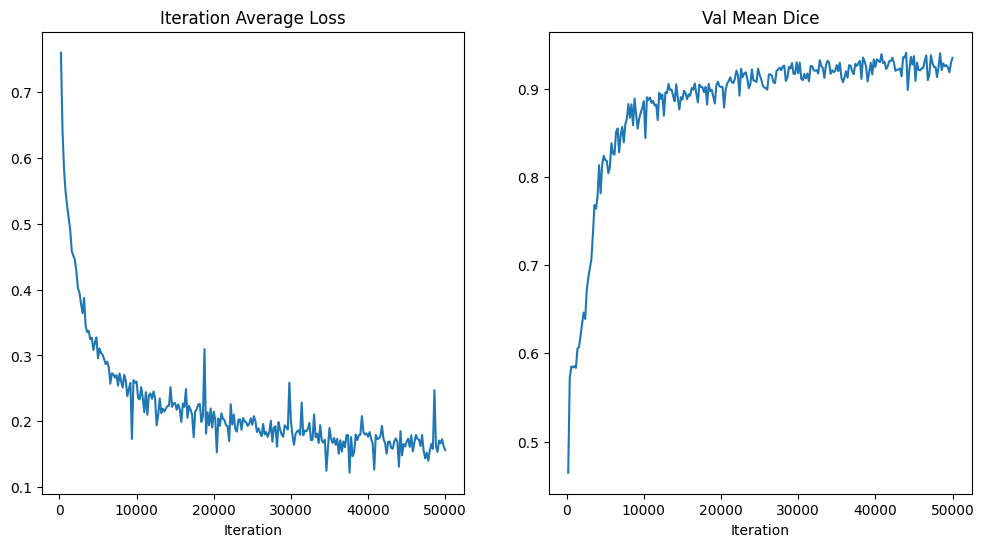

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
print(len(epoch_loss_values))
print(epoch_loss_values)

print(len(metric_values))
print(metric_values)

average_dice = sum(metric_values) / len(metric_values)
print(average_dice)

250
[0.7594759143315829, 0.6435164999961853, 0.5829537027590984, 0.5486506880546103, 0.5269496382259932, 0.5089287370035093, 0.49105189653003917, 0.45848503708839417, 0.45140764315923054, 0.44560980465677047, 0.4273940240725493, 0.4022425132639268, 0.39528508791847833, 0.37874908407529195, 0.36422376917011434, 0.3872973918914795, 0.34461288066471324, 0.33545629885689965, 0.33734900159079856, 0.32450760085627717, 0.32682787569669575, 0.3082048101471616, 0.3194511467486285, 0.3272719106503895, 0.29557521954963084, 0.3105447321168838, 0.30351168748944307, 0.3009327310052785, 0.294268946149456, 0.28672197291368173, 0.29044723944677103, 0.2820665521754159, 0.25702871524152304, 0.27286155454137107, 0.27134476519293255, 0.26617839684089023, 0.269894748494245, 0.25416602782997083, 0.27257062879300886, 0.2604956085031683, 0.25122204228587774, 0.27067416182586124, 0.2618293625877259, 0.23821831519825984, 0.24906084948862103, 0.2581962542720588, 0.17322121560573578, 0.2625308913680223, 0.25880779



---



Load the output model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Disertation/Project3/Paths/UNET/unet_bet_best_metric_model_6.pth'))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.5, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
                (D): Dropout(p=0.5, inplace=False)
                (A): PReLU(num_pa

Try running for one of the validation cases and display the results

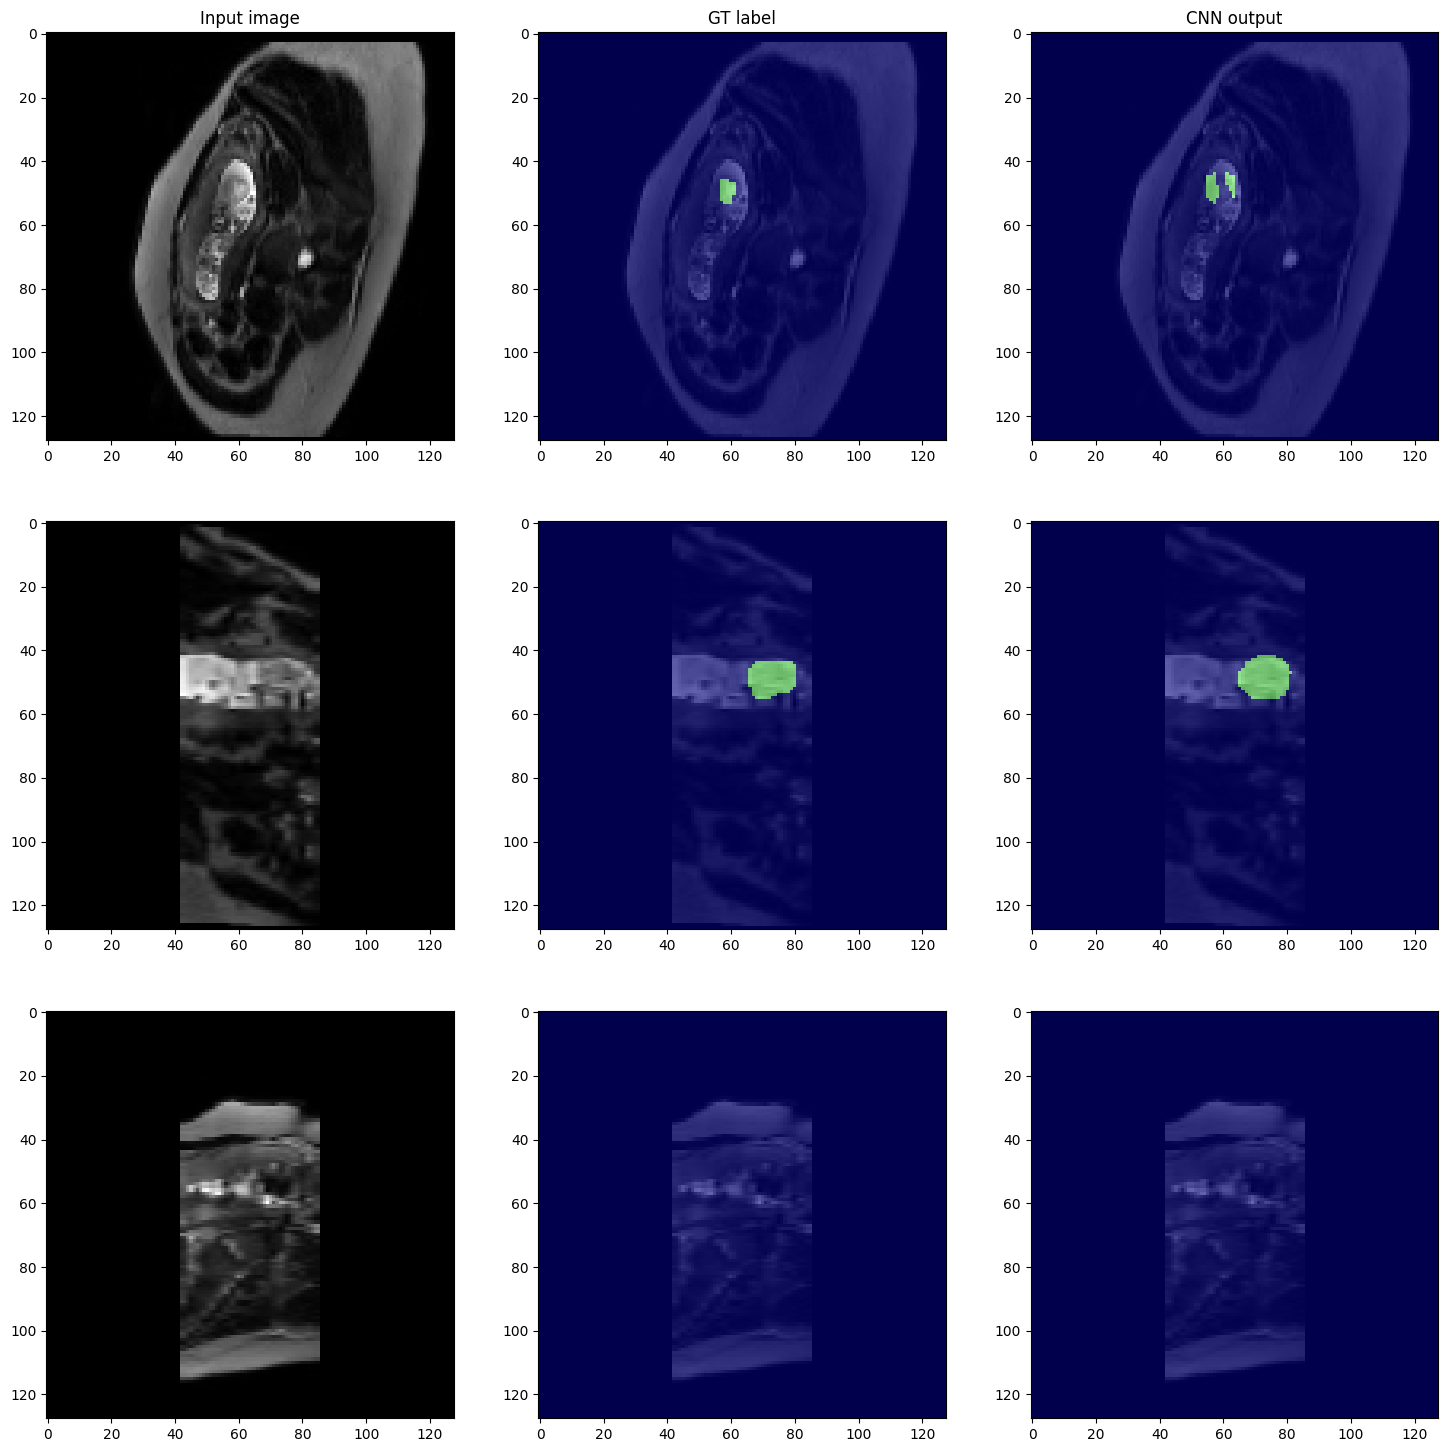

In [ ]:
case_num = 1

class_n = class_num
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = val_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title("Input image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.show()

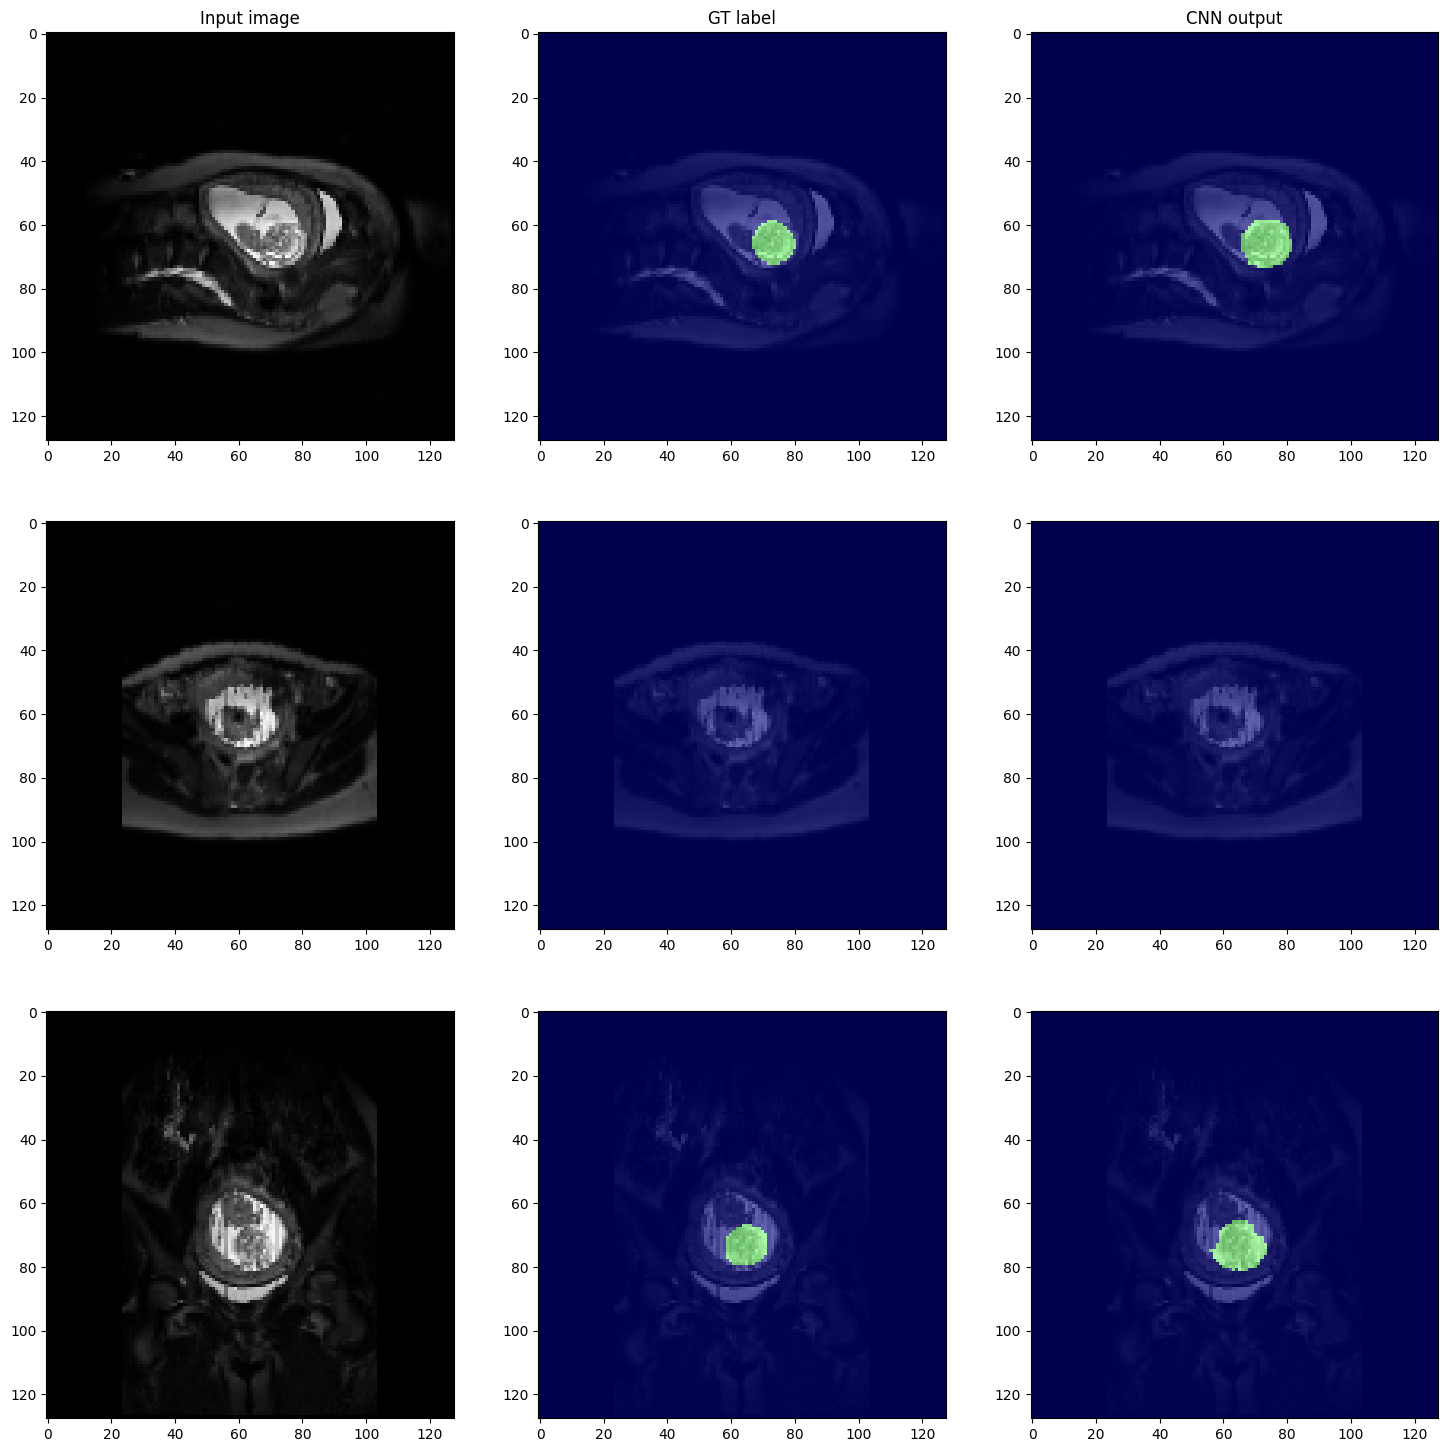

In [ ]:
case_num = 1

class_n = class_num
qq=round(img_dim/2)
alpha_val = 0.6
with torch.no_grad():
    img_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
    cur_case = test_ds[case_num]
    img = cur_case["image"]
    label = cur_case["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(
        val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
    )
    plt.figure("check", (18, 18))
    plt.subplot(3, 3, 1)
    plt.title("Input image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.subplot(3, 3, 2)
    plt.title("GT label")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 3)
    plt.title("CNN output")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, qq], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, qq], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.subplot(3, 3, 4)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.subplot(3, 3, 5)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 6)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, qq, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, qq, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")


    plt.subplot(3, 3, 7)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.subplot(3, 3, 8)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(val_labels.cpu().numpy()[0, 0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")
    plt.subplot(3, 3, 9)
    plt.imshow(val_inputs.cpu().numpy()[0, 0, qq, :, :], cmap="gray")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, qq, :, :], alpha=alpha_val, vmin=0, vmax=class_n, cmap="jet")

    plt.show()

Save CNN segmentation results for all validation images

In [ ]:

res_dir = root_dir + "/" + roi_type + "results_6"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


for x in range(len(val_files)):

  case_num = x
  img_name = val_files[case_num]["label"]
  label_name = val_files[case_num]["label"]
  case_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = val_ds[case_num]["image"]
      label = val_ds[case_num]["label"]
      val_inputs = torch.unsqueeze(img, 1).cuda()
      val_labels = torch.unsqueeze(label, 1).cuda()
      val_outputs = sliding_window_inference(
          val_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_results_6/cnn-lab-presto0013-stack-1002.nii.gz
1 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_results_6/cnn-lab-presto0016-stack-1002.nii.gz
2 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_results_6/cnn-lab-presto0033-stack-1002.nii.gz
3 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_results_6/cnn-lab-presto0041-stack-1002.nii.gz
4 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_results_6/cnn-lab-presto004102-stack-1002.nii.gz
5 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_results_6/cnn-lab-presto0048-stack-1002.nii.gz
6 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_results_6/cnn-lab-presto0052-stack-1002.nii.gz
7 /content/

In [ ]:

res_dir = root_dir + "/" + roi_type + "UNET_06_08"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"latest_metric_model_6.pth"))))
model.eval()

for x in range(len(test_files)):

  case_num = x
  img_name = test_files[case_num]["label"]
  label_name = test_files[case_num]["label"]
  case_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = test_ds[case_num]["image"]
      label = test_ds[case_num]["label"]
      test_inputs = torch.unsqueeze(img, 1).cuda()
      test_labels = torch.unsqueeze(label, 1).cuda()
      test_outputs = sliding_window_inference(
          test_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET_06_08/cnn-lab-stack-1000.nii.gz
1 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET_06_08/cnn-lab-stack-1001.nii.gz
2 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET_06_08/cnn-lab-stack-1002.nii.gz
3 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET_06_08/cnn-lab-stack-1003.nii.gz
4 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET_06_08/cnn-lab-stack-1004.nii.gz
5 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET_06_08/cnn-lab-stack-1005.nii.gz
6 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET_06_08/cnn-lab-stack-1006.nii.gz
7 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v

In [ ]:

res_dir = root_dir + "/" + roi_type + "UNET(2)_06_08"

isdir = os.path.isdir(res_dir)
if not isdir:
  os.mkdir(res_dir)


model.load_state_dict(torch.load(os.path.join(root_dir, (roi_type+"best_metric_model_6.pth"))))
model.eval()

for x in range(len(test_files)):

  case_num = x
  img_name = test_files[case_num]["label"]
  label_name = test_files[case_num]["label"]
  case_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
  out_name = res_dir + "/cnn-lab-" + case_name
  print(case_num, out_name)

  img_tmp_info = nib.load(img_name)

  with torch.no_grad():
      img_name = os.path.split(test_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
      img = test_ds[case_num]["image"]
      label = test_ds[case_num]["label"]
      test_inputs = torch.unsqueeze(img, 1).cuda()
      test_labels = torch.unsqueeze(label, 1).cuda()
      test_outputs = sliding_window_inference(
          test_inputs, (img_dim, img_dim, img_dim), 4, model, overlap=0.8
      )

      out_label = torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, :]
      out_lab_nii = nib.Nifti1Image(out_label, img_tmp_info.affine, img_tmp_info.header)
      nib.save(out_lab_nii, out_name)


0 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET(2)_06_08/cnn-lab-stack-1000.nii.gz
1 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET(2)_06_08/cnn-lab-stack-1001.nii.gz
2 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET(2)_06_08/cnn-lab-stack-1002.nii.gz
3 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET(2)_06_08/cnn-lab-stack-1003.nii.gz
4 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET(2)_06_08/cnn-lab-stack-1004.nii.gz
5 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET(2)_06_08/cnn-lab-stack-1005.nii.gz
6 /content/drive/MyDrive/Disertation/Project/training-dataset/traning-brain-1-lab-v1/unet_bet_UNET(2)_06_08/cnn-lab-stack-1006.nii.gz
7 /content/drive/MyDrive/Disertation/Project/training-dataset/